# DSPy 3.0.3 Medical Data Extraction Pipeline

This notebook demonstrates a comprehensive data extraction pipeline using DSPy 3.0.3 to extract structured dichotomous outcomes from medical research papers in markdown format.

## Objective
Extract structured data from medical research markdown  into the target format matching `dichotomous_outcomes.json`.


## 1. Setup and Dependencies


In [50]:
# Install DSPy 3.0.3 if not already installed
%pip install dspy-ai==3.0.3 openai pandas numpy scikit-learn matplotlib seaborn sentence-transformers


Note: you may need to restart the kernel to use updated packages.


In [51]:
import dspy
import json
import pandas as pd
import numpy as np
import re
import os
from typing import List, Dict, Any, Optional, Tuple
from dataclasses import dataclass
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import tiktoken
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
import hashlib
from scipy.optimize import linear_sum_assignment
import diskcache as dc

# Suppress warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

# Print DSPy version
print(f"DSPy version: {dspy.__version__}")

DSPy version: 3.0.3


## 2. Configure DSPy Language Model


In [52]:
# Set your API key (uncomment and add your key)
# os.environ["OPENAI_API_KEY"] = "your-api-key-here"

# Configure DSPy with OpenAI GPT-4o-mini for cost efficiency
lm = dspy.LM('gemini/gemini-2.5-pro', max_tokens=20000, temperature=1.0)
dspy.configure(lm=lm)

print("Language model configured successfully")


Language model configured successfully


## 3. Data Loading and Exploration


In [53]:
# Load source file
source_file = "/nlp/data/karthik9/Sprint1/Dental/Data/acute_pain_mds/2518_Kellstein_md/2518_Kellstein_md.json"
target_file = "/nlp/data/karthik9/Sprint1/Dental/Data/jsons/continuous_outcomes.json"

with open(source_file, 'r') as f:
    source_data = json.load(f)

with open(target_file, 'r') as f:
    target_data = json.load(f)

# Extract markdown content
markdown_content = source_data['marker']['markdown']

# Use OpenAI tokenizer (cl100k_base is the same one GPT-4/4o/5 use)
encoding = tiktoken.get_encoding("cl100k_base")
tokens = encoding.encode(markdown_content)

print(f"Markdown content length: {len(markdown_content)} characters")
print(f"Token count: {len(tokens)}")
print(f"Target data contains {len(target_data)} records")

Markdown content length: 45025 characters
Token count: 11849
Target data contains 723 records


In [54]:
# Filter target data for  study to understand expected output
one_study_records = [record for record in target_data if record.get('filename') == '2518_Kellstein']
print(f"Found {len(one_study_records)} records in target data")

# Show example record structure
if one_study_records:
    print("\nExample target record structure:")
    for key, value in one_study_records[0].items():
        print(f"{key}: {value}")


Found 25 records in target data

Example target record structure:
Ref_ID: 2518.0
First_Author: Kellstein
Trial_Name: 
Population: 2
Intervention_Code: 1
Intervention_Description: Ibuprofen 200 mg/Acetaminophen 500 mg
Outcome_Type: 1
Outcome_Other_Specify: 
Pain_Relief_Scale_Name: 
Pain_Relief_Scale_Type: categorical, ordinal
Pain_Relief_Scale_Range: 0-4
Pain_Relief_Scale_Questions: 0 = none, 1 = a little, 2 = some, 3 = a lot, and 4 = complete
Global_Efficacy_Scale_Name: 
Global_Efficacy_Scale_Type: 
Global_Efficacy_Scale_Range: 
Global_Efficacy_Scale_Questions: 
TOTPAR_Definition: 
TOTPAR_Scale_Name: 
TOTPAR_Scale_Type: 
TOTPAR_Scale_Range: 
TOTPAR_Scale_Questions: 
SPID_Definition: 
SPID_Scale_Name: 
SPID_Scale_Type: 
SPID_Scale_Range: 
SPID_Scale_Questions: 
N_Analyzed: 90
Central_Tendency_Type: 1
Central_Tendency_Value: 2.47
Variability_Type: NR
Variability_Value: NR
Other_Results: 
Comments: Webplot from fig 2; During that time, study participants provided self-ratings of pain seve

## 4. DSPy Signature Definitions

We'll define specialized signatures for each extraction task:


In [55]:
class ExtractStudyMetadata(dspy.Signature):
    """Extract basic study metadata from medical research paper markdown.
    
    This extracts core identifying information about the study including reference ID,
    author information, trial name, and population type for pain management research.
    """
    
    markdown_content: str = dspy.InputField(desc="Full markdown content of the medical research paper")
    
    first_author: str = dspy.OutputField(
        desc="Last name of the first author (e.g., 'Cooper', 'Seymour'). Extract only the surname."
    )
    
    
    population_code: str = dspy.OutputField(
        desc="Numeric code representing the study population type. Codes: 1=simple tooth extraction, 2=surgical tooth extraction (third molar/wisdom teeth), 3=surgical tooth extraction (other teeth), 4=pulpitis or its complications. Can be multiple codes separated by commas (e.g., '2, 3')"
    )


class ExtractInterventions(dspy.Signature):
    """Extract intervention details from medical research paper markdown.
    
    This extracts information about pain management interventions including
    intervention codes and detailed descriptions with dosages.
    """
    
    markdown_content: str = dspy.InputField(desc="Full markdown content of the medical research paper")
    
    interventions_json: str = dspy.OutputField(
        desc="""JSON string containing list of interventions. Each intervention object must have:
        - intervention_code (integer): Numeric code 1-11 where:
          1=Ibuprofen 200-400mg + Acetaminophen 500-1000mg
          2=Oxycodone 5mg or Codeine 60mg  
          3=Acetaminophen 650mg + Oxycodone 10mg
          4=Ibuprofen 200mg + Hydrocodone 5mg
          5=Hydrocodone 5mg + Acetaminophen 300-325mg
          6=Ibuprofen 400mg (fast acting or acid)
          7=Tramadol 37.5mg + Acetaminophen 325mg
          8=Acetaminophen 500-1000mg
          9=Acetaminophen 600-650mg + Codeine 60mg
          10=Naproxen 400-440mg
          11=Placebo/no treatment
        - intervention_description (string): Full description with medication name and exact dose (e.g., "Ibuprofen 400 mg", "Paracetamol 500 mg", "NA" for placebo)
        
        Example: [{"intervention_code": 6, "intervention_description": "Ibuprofen 400 mg"}, {"intervention_code": 8, "intervention_description": "Paracetamol 500 mg"}]"""
    )


class ExtractOutcomeTypes(dspy.Signature):
    """Identify which types of continuous outcomes are reported in the medical research paper.
    
    This focuses on identifying what outcomes are present before extracting detailed data.
    """
    
    markdown_content: str = dspy.InputField(desc="Full markdown content of the medical research paper")
    intervention_description: str = dspy.InputField(desc="Specific intervention to check outcomes for")
    
    outcome_types_json: str = dspy.OutputField(
        desc="""JSON string containing list of outcome types present for this intervention. Each outcome type object must have:
        - outcome_code (integer): Outcome type code where:
          1=Pain relief at 6 hours
          2=Pain relief at 7 hours  
          3=Pain relief at 8 hours
          4=Pain relief at 48 hours
          5=TOTPAR over 6 hours
          6=TOTPAR over 7 hours
          7=TOTPAR over 8 hours
          8=TOTPAR over 48 hours
          9=SPID over 6 hours
          10=SPID over 7 hours
          11=SPID over 8 hours
          12=SPID over 12 hours
          13=Global subjective efficacy ratings at 6 hours
          14=Global subjective efficacy ratings at 7 hours
          15=Global subjective efficacy ratings at 8 hours
          16=Global subjective efficacy ratings at 48 hours
        - outcome_category (string): Category of outcome ("pain_relief", "totpar", "spid", "global_efficacy", "other")
        - time_point (string): Time point for this outcome (e.g., "6 hours", "7 hours", "8 hours", "48 hours")
        - outcome_other_specify (string): If outcome_code=17, specify what the other outcome is. Use "NA" otherwise.
        
        Example: [
          {"outcome_code": 1, "outcome_category": "pain_relief", "time_point": "6 hours", "outcome_other_specify": "NA"},
          {"outcome_code": 13, "outcome_category": "global_efficacy", "time_point": "6 hours", "outcome_other_specify": "NA"}
        ]"""
    )


class ExtractPainReliefDetails(dspy.Signature):
    """Extract detailed pain relief measurement information for pain relief outcomes (codes 1-4).
    
    This extracts comprehensive details about how pain relief was measured and assessed.
    """
    
    markdown_content: str = dspy.InputField(desc="Full markdown content of the medical research paper")
    intervention_description: str = dspy.InputField(desc="Specific intervention for this outcome")
    outcome_code: int = dspy.InputField(desc="Pain relief outcome code (1-4)")
    time_point: str = dspy.InputField(desc="Time point (e.g., '6 hours', '7 hours', '8 hours', '48 hours')")
    
    pain_relief_details_json: str = dspy.OutputField(
        desc="""JSON string with comprehensive pain relief measurement details:
        - type_of_scale_used (string): Type of scale used to collect this data (e.g., "ordinal, categorical", "VAS", "numerical rating scale", "Likert scale")
        - name_of_scale_used (string): Specific name of the scale used (e.g., "5-point categorical pain relief scale", "Visual Analog Scale", "Categorical Pain Relief Scale")
        - range_of_scale_used (string): Range of the scale (e.g., "0-4", "0-10", "1-5", "0-100mm")
        - copy_paste_scale (string): Exact verbatim description of the scale as written in the paper (e.g., "0=no relief, 1=a little relief, 2=some relief, 3=a lot of relief, 4=complete relief")
        - all_scale_responses (string): All possible response options/categories listed verbatim (e.g., "complete (4), a lot (3), some (2), a little (1), none (0)")
        - extraction_notes (string): Source location and extraction methodology
        - additional_details (string): Any additional relevant information about the pain relief assessment
        
        Example: {"type_of_scale_used": "ordinal, categorical", "name_of_scale_used": "5-point categorical pain relief scale", "range_of_scale_used": "0-4", "copy_paste_scale": "patients recorded level of pain relief as complete (4), a lot (3), some (2), a little (1), or none (0)", "all_scale_responses": "complete (4), a lot (3), some (2), a little (1), none (0)", "extraction_notes": "From methods section, Figure II caption", "additional_details": "Pain relief assessed hourly for 6 hours post-dose"}"""
    )


class ExtractGlobalEfficacyDetails(dspy.Signature):
    """Extract detailed global subjective efficacy measurement information for global efficacy outcomes (codes 13-16).
    
    This extracts comprehensive details about how global subjective efficacy was measured and assessed.
    """
    
    markdown_content: str = dspy.InputField(desc="Full markdown content of the medical research paper")
    intervention_description: str = dspy.InputField(desc="Specific intervention for this outcome")
    outcome_code: int = dspy.InputField(desc="Global efficacy outcome code (13-16)")
    time_point: str = dspy.InputField(desc="Time point (e.g., '6 hours', '7 hours', '8 hours', '48 hours')")
    
    global_efficacy_details_json: str = dspy.OutputField(
        desc="""JSON string with comprehensive global subjective efficacy measurement details:
        - type_of_scale_used (string): Type of scale used to collect this data (e.g., "ordinal, categorical", "Likert scale", "VAS")
        - name_of_scale_used (string): Specific name of the scale used (e.g., "Global evaluation scale", "Patient global assessment", "Overall medication assessment")
        - range_of_scale_used (string): Range of the scale (e.g., "1-5", "0-4", "0-10", "1-4")
        - copy_paste_scale (string): Exact verbatim description of the scale as written in the paper
        - all_scale_responses (string): All possible response options/categories listed verbatim (e.g., "excellent, very good, good, fair, poor")
        - extraction_notes (string): Source location and extraction methodology
        - additional_details (string): Any additional relevant information about the global efficacy assessment
        
        Example: {"type_of_scale_used": "ordinal, categorical", "name_of_scale_used": "Patient global assessment of medication", "range_of_scale_used": "1-5", "copy_paste_scale": "patients recorded their overall impression of the study medication as excellent (1), very good (2), good (3), fair (4), or poor (5)", "all_scale_responses": "excellent (1), very good (2), good (3), fair (4), poor (5)", "extraction_notes": "From methods section and Table 3", "additional_details": "Assessment performed at end of study period"}"""
    )


class ExtractTOTPARDetails(dspy.Signature):
    """Extract detailed TOTPAR measurement information for TOTPAR outcomes (codes 5-8).
    
    This extracts comprehensive details about how TOTPAR was calculated and the underlying scales used.
    """
    
    markdown_content: str = dspy.InputField(desc="Full markdown content of the medical research paper")
    intervention_description: str = dspy.InputField(desc="Specific intervention for this outcome")
    outcome_code: int = dspy.InputField(desc="TOTPAR outcome code (5-8)")
    time_point: str = dspy.InputField(desc="Time point (e.g., '6 hours', '7 hours', '8 hours', '48 hours')")
    
    totpar_details_json: str = dspy.OutputField(
        desc="""JSON string with comprehensive TOTPAR measurement details:
        - copy_paste_scale (string): Exact verbatim description of the underlying pain relief scale used for TOTPAR calculation
        - definition_of_totpar (string): Definition of TOTPAR as indicated by study authors (exact quote from paper)
        - name_of_scale_used (string): Name of the underlying scale used for TOTPAR calculation
        - type_of_scale_used (string): Type of underlying scale (e.g., "ordinal, categorical", "VAS", "numerical rating")
        - range_of_scale_used (string): Range of the underlying scale used for TOTPAR calculation
        - copy_paste_scale_questions (string): Copy/paste the scale question(s) and all response options used for pain relief assessment
        - all_scale_responses (string): All possible responses for the underlying pain relief scale
        - calculation_method (string): How TOTPAR was calculated (e.g., "sum of hourly pain relief scores", "area under curve")
        - time_points_included (string): Specific time points included in TOTPAR calculation
        - extraction_notes (string): Source location and extraction methodology
        - additional_details (string): Any additional relevant information about TOTPAR methodology
        
        Example: {"copy_paste_scale": "patients recorded level of pain relief as complete (4), a lot (3), some (2), a little (1), or none (0)", "definition_of_totpar": "The sum of total pain relief (TOTPAR) scores was calculated by adding the pain relief scores at each time point", "name_of_scale_used": "5-point categorical pain relief scale", "type_of_scale_used": "ordinal, categorical", "range_of_scale_used": "0-4", "copy_paste_scale_questions": "How much pain relief have you experienced? Complete relief (4), A lot of relief (3), Some relief (2), A little relief (1), No relief (0)", "all_scale_responses": "complete (4), a lot (3), some (2), a little (1), none (0)", "calculation_method": "sum of hourly pain relief scores from 0-6 hours", "time_points_included": "0.5, 1, 1.5, 2, 3, 4, 5, 6 hours", "extraction_notes": "From methods section and statistical analysis", "additional_details": "TOTPAR calculated for 6-hour period post-dose"}"""
    )


class ExtractSPIDDetails(dspy.Signature):
    """Extract detailed SPID measurement information for SPID outcomes (codes 9-12).
    
    This extracts comprehensive details about how SPID was calculated and the underlying scales used.
    """
    
    markdown_content: str = dspy.InputField(desc="Full markdown content of the medical research paper")
    intervention_description: str = dspy.InputField(desc="Specific intervention for this outcome")
    outcome_code: int = dspy.InputField(desc="SPID outcome code (9-12)")
    time_point: str = dspy.InputField(desc="Time point (e.g., '6 hours', '7 hours', '8 hours', '48 hours')")
    
    spid_details_json: str = dspy.OutputField(
        desc="""JSON string with comprehensive SPID measurement details:
        - copy_paste_scale (string): Exact verbatim description of the underlying pain intensity scale used for SPID calculation
        - definition_of_spid (string): Definition of SPID as indicated by study authors (exact quote from paper)
        - name_of_scale_used (string): Name of the underlying scale used for SPID calculation
        - type_of_scale_used (string): Type of underlying scale (e.g., "VAS", "numerical rating scale", "categorical")
        - range_of_scale_used (string): Range of the underlying scale used for SPID calculation
        - copy_paste_scale_questions (string): Copy/paste the scale question(s) and all response options used for pain intensity assessment
        - all_scale_responses (string): All possible responses for the underlying pain intensity scale
        - calculation_method (string): How SPID was calculated (e.g., "sum of pain intensity differences", "area under curve")
        - time_points_included (string): Specific time points included in SPID calculation
        - extraction_notes (string): Source location and extraction methodology
        - additional_details (string): Any additional relevant information about SPID methodology
        
        Example: {"copy_paste_scale": "patients rated pain intensity on a 0-10 numerical rating scale where 0=no pain and 10=worst possible pain", "definition_of_spid": "The sum of pain intensity differences (SPID) scores were calculated by adding the pain intensity difference scores at each time point", "name_of_scale_used": "11-point numerical rating scale", "type_of_scale_used": "numerical rating scale", "range_of_scale_used": "0-10", "copy_paste_scale_questions": "Rate your current pain intensity: 0=no pain, 1-3=mild pain, 4-6=moderate pain, 7-10=severe pain", "all_scale_responses": "0=no pain, 1=minimal, 2=mild, 3=mild, 4=moderate, 5=moderate, 6=moderate, 7=severe, 8=severe, 9=severe, 10=worst possible", "calculation_method": "sum of hourly pain intensity difference scores", "time_points_included": "0.5, 1, 1.5, 2, 3, 4, 5, 6 hours", "extraction_notes": "From methods section and Figure 1", "additional_details": "Pain intensity differences calculated as baseline minus post-dose scores"}"""
    )


# class ExtractOtherOutcomeDetails(dspy.Signature):
#     """Extract detailed measurement information for other continuous outcomes (code 17).
    
#     This extracts comprehensive details about how other outcomes were measured.
#     """
    
#     markdown_content: str = dspy.InputField(desc="Full markdown content of the medical research paper")
#     intervention_description: str = dspy.InputField(desc="Specific intervention for this outcome")
#     outcome_other_specify: str = dspy.InputField(desc="Specific description of the other outcome")
    
#     other_outcome_details_json: str = dspy.OutputField(
#         desc="""JSON string with comprehensive other outcome measurement details:
#         - outcome_name (string): Name of the specific other outcome
#         - type_of_scale_used (string): Type of scale used to collect this data
#         - name_of_scale_used (string): Specific name of the scale used
#         - range_of_scale_used (string): Range of the scale
#         - copy_paste_scale (string): Exact verbatim description of the scale as written in the paper
#         - all_scale_responses (string): All possible response options/categories listed verbatim
#         - measurement_method (string): How the outcome was measured
#         - time_points (string): When the outcome was assessed
#         - extraction_notes (string): Source location and extraction methodology
#         - additional_details (string): Any additional relevant information
        
#         Example: {"outcome_name": "Time to meaningful pain relief", "type_of_scale_used": "time measurement", "name_of_scale_used": "stopwatch timing", "range_of_scale_used": "0-360 minutes", "copy_paste_scale": "time from first dose to when patient reported meaningful pain relief", "all_scale_responses": "continuous time measurement in minutes", "measurement_method": "patient-reported time to first meaningful relief", "time_points": "continuously monitored for 6 hours", "extraction_notes": "From Table 4 and methods", "additional_details": "Meaningful relief defined as 50% reduction in pain intensity"}"""
#     )


class ExtractStatisticalData(dspy.Signature):
    """Extract statistical measures and numerical data for a specific outcome.
    
    This extracts the quantitative results including sample sizes, central tendency, and variability measures.
    """
    
    markdown_content: str = dspy.InputField(desc="Full markdown content of the medical research paper")
    intervention_description: str = dspy.InputField(desc="Specific intervention for this outcome")
    outcome_code: int = dspy.InputField(desc="Specific outcome code (1-17)")
    time_point: str = dspy.InputField(desc="Time point for this outcome")
    
    statistical_data_json: str = dspy.OutputField(
        desc="""JSON string with statistical measures for this specific outcome:
        - n_analyzed (integer): Number of participants analyzed for this outcome
        - measure_of_central_tendency (string): Type of central tendency reported (e.g., "mean", "median", "mode")
        - central_tendency_value (float): Actual value of central tendency measure. Use null if not reported.
        - measure_of_variability (string): Type of variability measure (e.g., "SD", "SE", "IQR", "95% CI", "NR")
        - variability_value (string): Value of variability measure (may include ranges like "1.2-2.4" or "NR")
        - other_reporting_method (string): If other reporting methods are used, include results here. Use "NA" if standard reporting.
        - data_source (string): Source of the data (e.g., "Table 1", "Figure II", "Supplementary materials")
        - extraction_method (string): How data was extracted (e.g., "direct from table", "digitized from figure", "calculated")
        
        Example: {"n_analyzed": 37, "measure_of_central_tendency": "mean", "central_tendency_value": 1.51, "measure_of_variability": "SD", "variability_value": "1.2", "other_reporting_method": "NA", "data_source": "Figure II", "extraction_method": "Webplot digitizer used to extract mean from graph"}"""
    )


class StructureCompleteRecord(dspy.Signature):
    """Structure all extracted data into the final comprehensive CSV format.
    
    This combines study metadata, intervention details, outcome types, outcome details, 
    and statistical data into the standardized format with all required fields.
    """
    
    study_metadata_json: str = dspy.InputField(desc="Study metadata with  first_author,  population_code")
    intervention_json: str = dspy.InputField(desc="Intervention details with intervention_code, intervention_description")
    outcome_type_json: str = dspy.InputField(desc="Outcome type with outcome_code, outcome_category, time_point")
    outcome_details_json: str = dspy.InputField(desc="Detailed outcome information based on category")
    statistical_data_json: str = dspy.InputField(desc="Statistical measures and numerical data")
    
    final_record_json: str = dspy.OutputField(
        desc="""Complete structured record as JSON string with exactly these fields:
     
        - First_Author (string): First author last name  
       
        - Population (string): Population code (can be multiple like "2, 3")
        - Intervention_Code (integer): Intervention code (1-11)
        - Intervention_Description (string): Full intervention description with dose
        - Outcome_Code (integer): Outcome type code (1-17)
        - Outcome_Other_Specify (string): Specific outcome description if code=17, otherwise "NA"
        
        PAIN RELIEF FIELDS (fill only for codes 1-4, "NA" for others):
        - Pain_Relief_Type_Of_Scale (string): Type of scale used for pain relief
        - Pain_Relief_Name_Of_Scale (string): Name of scale used for pain relief
        - Pain_Relief_Range_Of_Scale (string): Range of scale used for pain relief
        - Pain_Relief_Copy_Paste_Scale (string): Verbatim scale description for pain relief
        - Pain_Relief_All_Responses (string): All response options for pain relief scale
        
        GLOBAL EFFICACY FIELDS (fill only for codes 13-16, "NA" for others):
        - Global_Efficacy_Type_Of_Scale (string): Type of scale used for global efficacy
        - Global_Efficacy_Name_Of_Scale (string): Name of scale used for global efficacy
        - Global_Efficacy_Range_Of_Scale (string): Range of scale used for global efficacy
        - Global_Efficacy_Copy_Paste_Scale (string): Verbatim scale description for global efficacy
        - Global_Efficacy_All_Responses (string): All response options for global efficacy scale
        
        TOTPAR FIELDS (fill only for codes 5-8, "NA" for others):
        - TOTPAR_Copy_Paste_Scale (string): Verbatim underlying scale for TOTPAR
        - TOTPAR_Definition (string): Definition of TOTPAR by study authors
        - TOTPAR_Name_Of_Scale (string): Name of underlying scale for TOTPAR
        - TOTPAR_Type_Of_Scale (string): Type of underlying scale for TOTPAR
        - TOTPAR_Range_Of_Scale (string): Range of underlying scale for TOTPAR
        - TOTPAR_Copy_Paste_Questions (string): Scale questions and responses for TOTPAR
        - TOTPAR_All_Responses (string): All responses for underlying TOTPAR scale
        
        SPID FIELDS (fill only for codes 9-12, "NA" for others):
        - SPID_Copy_Paste_Scale (string): Verbatim underlying scale for SPID
        - SPID_Definition (string): Definition of SPID by study authors
        - SPID_Name_Of_Scale (string): Name of underlying scale for SPID
        - SPID_Type_Of_Scale (string): Type of underlying scale for SPID
        - SPID_Range_Of_Scale (string): Range of underlying scale for SPID
        - SPID_Copy_Paste_Questions (string): Scale questions and responses for SPID
        - SPID_All_Responses (string): All responses for underlying SPID scale
        
        STATISTICAL MEASURES:
        - N_Analyzed (integer): Number of participants analyzed
        - Measure_Of_Central_Tendency (string): Type of central tendency
        - Central_Tendency_Value (float): Central tendency value (can be null)
        - Measure_Of_Variability (string): Type of variability measure
        - Variability_Value (string): Variability value
        - Other_Reporting_Method (string): Alternative reporting methods if used, "NA" otherwise
        - Comments (string): Comprehensive extraction notes, methodology, data sources, and additional details
        
        FIELD MAPPING RULES:
        - For pain relief outcomes (1-4): Fill pain relief fields, set all others to "NA"
        - For TOTPAR outcomes (5-8): Fill TOTPAR fields, set all others to "NA"
        - For SPID outcomes (9-12): Fill SPID fields, set all others to "NA" 
        - For global efficacy (13-16): Fill global efficacy fields, set all others to "NA"
        - For other outcomes (17): Fill outcome_other_specify, set specific fields to "NA"
        
        Example: { "First_Author": "Cooper",  "Population": "2, 3", "Intervention_Code": 6, "Intervention_Description": "Ibuprofen 400 mg", "Outcome_Code": 1, "Outcome_Other_Specify": "NA", "Pain_Relief_Type_Of_Scale": "ordinal, categorical", "Pain_Relief_Name_Of_Scale": "5-point categorical pain relief scale", "Pain_Relief_Range_Of_Scale": "0-4", "Pain_Relief_Copy_Paste_Scale": "patients recorded level of pain relief as complete (4), a lot (3), some (2), a little (1), or none (0)", "Pain_Relief_All_Responses": "complete (4), a lot (3), some (2), a little (1), none (0)", "Global_Efficacy_Type_Of_Scale": "NA", "Global_Efficacy_Name_Of_Scale": "NA", "Global_Efficacy_Range_Of_Scale": "NA", "Global_Efficacy_Copy_Paste_Scale": "NA", "Global_Efficacy_All_Responses": "NA", "TOTPAR_Copy_Paste_Scale": "NA", "TOTPAR_Definition": "NA", "TOTPAR_Name_Of_Scale": "NA", "TOTPAR_Type_Of_Scale": "NA", "TOTPAR_Range_Of_Scale": "NA", "TOTPAR_Copy_Paste_Questions": "NA", "TOTPAR_All_Responses": "NA", "SPID_Copy_Paste_Scale": "NA", "SPID_Definition": "NA", "SPID_Name_Of_Scale": "NA", "SPID_Type_Of_Scale": "NA", "SPID_Range_Of_Scale": "NA", "SPID_Copy_Paste_Questions": "NA", "SPID_All_Responses": "NA", "N_Analyzed": 37, "Measure_Of_Central_Tendency": "mean", "Central_Tendency_Value": 1.51, "Measure_Of_Variability": "NR", "Variability_Value": "NR", "Other_Reporting_Method": "NA", "Comments": "Data extracted from Figure II using Webplot digitizer; single dose study; pain relief recorded hourly by patients"}"""
    )


In [56]:
def safe_json_parse(json_string, fallback=None):
    """Robust JSON parser with multiple recovery strategies."""
    if fallback is None:
        fallback = {}
    
    if not json_string or not isinstance(json_string, str):
        return fallback
    
    # Clean markdown fences first
    import re
    json_string = re.sub(r"```[a-zA-Z]*\n?", "", json_string).replace("```", "")
    json_string = json_string.strip()
    
    # Strategy 1: Direct parsing
    try:
        result = json.loads(json_string)
        if isinstance(result, str) and result.strip().startswith(("{", "[")):
            return safe_json_parse(result, fallback)
        return result
    except json.JSONDecodeError:
        pass
    
    # Strategy 2: Clean common issues and handle nested single quotes
    try:
        cleaned = json_string.strip()
        cleaned = cleaned.replace('\n', '\\n').replace('\r', '\\r').replace('\t', '\\t')
        cleaned = re.sub(r',(\s*[}\]])', r'\1', cleaned)
        
        if cleaned.startswith("'") or "': '" in cleaned or "': {'" in cleaned:
            cleaned = cleaned.replace("'", '"')
            cleaned = cleaned.replace('""', '"')
        else:
            cleaned = re.sub(r"'([^']*)':", r'"\1":', cleaned)
            cleaned = re.sub(r":\s*'([^']*)'", r': "\1"', cleaned)
        
        result = json.loads(cleaned)
        if isinstance(result, str) and result.strip().startswith(("{", "[")):
            return safe_json_parse(result, fallback)
        return result
    except (json.JSONDecodeError, AttributeError):
        pass
    
    # Strategy 3: Extract key-value pairs manually
    try:
        data = {}
        for match in re.finditer(r'"([^"]+)":\s*(\d+(?:\.\d+)?)', json_string):
            key, value = match.groups()
            data[key] = float(value) if '.' in value else int(value)
        
        for match in re.finditer(r'"([^"]+)":\s*"([^"]*)"', json_string):
            key, value = match.groups()
            data[key] = value
        
        for match in re.finditer(r'"([^"]+)":\s*(true|false)', json_string):
            key, value = match.groups()
            data[key] = value == 'true'
        
        if data:
            return data
    except:
        pass
    
    return fallback


## 5. DSPy Module Implementation

Now we'll create DSPy modules that use these signatures with reasoning patterns:


In [57]:

class StudyMetadataExtractor(dspy.Module):
    """Module to extract study metadata using chain of thought reasoning."""
    
    def __init__(self):
        super().__init__()
        self.extract_metadata = dspy.ChainOfThought(ExtractStudyMetadata)
    
    def forward(self, markdown_content: str) -> Dict[str, Any]:
        result = self.extract_metadata(markdown_content=markdown_content)
        return {
            
            "first_author": result.first_author,
         
            "population_code": result.population_code
        }


class InterventionExtractor(dspy.Module):
    """Module to extract intervention details."""
    
    def __init__(self):
        super().__init__()
        self.extract_interventions = dspy.ChainOfThought(ExtractInterventions)
    
    def forward(self, markdown_content: str) -> List[Dict[str, Any]]:
        result = self.extract_interventions(markdown_content=markdown_content)
        try:
            return safe_json_parse(result.interventions_json)
        except json.JSONDecodeError:
            print("Error parsing interventions JSON, returning empty list")
            return []


class OutcomeTypeExtractor(dspy.Module):
    """Module to identify which outcome types are present."""
    
    def __init__(self):
        super().__init__()
        self.extract_outcome_types = dspy.ChainOfThought(ExtractOutcomeTypes)
    
    def forward(self, markdown_content: str, intervention_description: str) -> List[Dict[str, Any]]:
        result = self.extract_outcome_types(
            markdown_content=markdown_content,
            intervention_description=intervention_description
        )
        try:
            return safe_json_parse(result.outcome_types_json)
        except json.JSONDecodeError:
            print("Error parsing outcome types JSON, returning empty list")
            return []


class PainReliefDetailExtractor(dspy.Module):
    """Module to extract detailed pain relief measurement information."""
    
    def __init__(self):
        super().__init__()
        self.extract_pain_relief_details = dspy.ChainOfThought(ExtractPainReliefDetails)
    
    def forward(self, markdown_content: str, intervention_description: str, 
                outcome_code: int, time_point: str) -> Dict[str, Any]:
        result = self.extract_pain_relief_details(
            markdown_content=markdown_content,
            intervention_description=intervention_description,
            outcome_code=outcome_code,
            time_point=time_point
        )
        try:
            return safe_json_parse(result.pain_relief_details_json)
        except json.JSONDecodeError:
            print('_'*50)
            print(result.pain_relief_details_json)
            print('_'*50)
            print("Error parsing pain relief details JSON, returning basic structure")
            return {
                "type_of_scale_used": "",
                "name_of_scale_used": "",
                "range_of_scale_used": "",
                "copy_paste_scale": "",
                "all_scale_responses": "",
                "extraction_notes": "Error in parsing",
                "additional_details": ""
            }


class GlobalEfficacyDetailExtractor(dspy.Module):
    """Module to extract detailed global efficacy measurement information."""
    
    def __init__(self):
        super().__init__()
        self.extract_global_efficacy_details = dspy.ChainOfThought(ExtractGlobalEfficacyDetails)
    
    def forward(self, markdown_content: str, intervention_description: str, 
                outcome_code: int, time_point: str) -> Dict[str, Any]:
        result = self.extract_global_efficacy_details(
            markdown_content=markdown_content,
            intervention_description=intervention_description,
            outcome_code=outcome_code,
            time_point=time_point
        )
        try:
            return safe_json_parse(result.global_efficacy_details_json)
        except json.JSONDecodeError:
            print("Error parsing global efficacy details JSON, returning basic structure")
            return {
                "type_of_scale_used": "",
                "name_of_scale_used": "",
                "range_of_scale_used": "",
                "copy_paste_scale": "",
                "all_scale_responses": "",
                "extraction_notes": "Error in parsing",
                "additional_details": ""
            }


class TOTPARDetailExtractor(dspy.Module):
    """Module to extract detailed TOTPAR measurement information."""
    
    def __init__(self):
        super().__init__()
        self.extract_totpar_details = dspy.ChainOfThought(ExtractTOTPARDetails)
    
    def forward(self, markdown_content: str, intervention_description: str, 
                outcome_code: int, time_point: str) -> Dict[str, Any]:
        result = self.extract_totpar_details(
            markdown_content=markdown_content,
            intervention_description=intervention_description,
            outcome_code=outcome_code,
            time_point=time_point
        )
        try:
            return safe_json_parse(result.totpar_details_json)
        except json.JSONDecodeError:
            print('_'*50)
            print(result.totpar_details_json)
            print('_'*50)
            print("Error parsing TOTPAR details JSON, returning basic structure")
            return {
                "copy_paste_scale": "",
                "definition_of_totpar": "",
                "name_of_scale_used": "",
                "type_of_scale_used": "",
                "range_of_scale_used": "",
                "copy_paste_scale_questions": "",
                "all_scale_responses": "",
                "calculation_method": "",
                "time_points_included": "",
                "extraction_notes": "Error in parsing",
                "additional_details": ""
            }


class SPIDDetailExtractor(dspy.Module):
    """Module to extract detailed SPID measurement information."""
    
    def __init__(self):
        super().__init__()
        self.extract_spid_details = dspy.ChainOfThought(ExtractSPIDDetails)
    
    def forward(self, markdown_content: str, intervention_description: str, 
                outcome_code: int, time_point: str) -> Dict[str, Any]:
        result = self.extract_spid_details(
            markdown_content=markdown_content,
            intervention_description=intervention_description,
            outcome_code=outcome_code,
            time_point=time_point
        )
        try:
            return safe_json_parse(result.spid_details_json)
        except json.JSONDecodeError:
            print("Error parsing SPID details JSON, returning basic structure")
            return {
                "copy_paste_scale": "",
                "definition_of_spid": "",
                "name_of_scale_used": "",
                "type_of_scale_used": "",
                "range_of_scale_used": "",
                "copy_paste_scale_questions": "",
                "all_scale_responses": "",
                "calculation_method": "",
                "time_points_included": "",
                "extraction_notes": "Error in parsing",
                "additional_details": ""
            }


# class OtherOutcomeDetailExtractor(dspy.Module):
#     """Module to extract detailed other outcome measurement information."""
    
#     def __init__(self):
#         super().__init__()
#         self.extract_other_outcome_details = dspy.ChainOfThought(ExtractOtherOutcomeDetails)
    
#     def forward(self, markdown_content: str, intervention_description: str, 
#                 outcome_other_specify: str) -> Dict[str, Any]:
#         result = self.extract_other_outcome_details(
#             markdown_content=markdown_content,
#             intervention_description=intervention_description,
#             outcome_other_specify=outcome_other_specify
#         )
#         try:
#             return safe_json_parse(result.other_outcome_details_json)
#         except json.JSONDecodeError:
#             print("Error parsing other outcome details JSON, returning basic structure")
#             return {
#                 "outcome_name": outcome_other_specify,
#                 "type_of_scale_used": "",
#                 "name_of_scale_used": "",
#                 "range_of_scale_used": "",
#                 "copy_paste_scale": "",
#                 "all_scale_responses": "",
#                 "measurement_method": "",
#                 "time_points": "",
#                 "extraction_notes": "Error in parsing",
#                 "additional_details": ""
#             }


class StatisticalDataExtractor(dspy.Module):
    """Module to extract statistical measures and numerical data."""
    
    def __init__(self):
        super().__init__()
        self.extract_statistical_data = dspy.ChainOfThought(ExtractStatisticalData)
    
    def forward(self, markdown_content: str, intervention_description: str, 
                outcome_code: int, time_point: str) -> Dict[str, Any]:
        result = self.extract_statistical_data(
            markdown_content=markdown_content,
            intervention_description=intervention_description,
            outcome_code=outcome_code,
            time_point=time_point
        )
        try:
            return safe_json_parse(result.statistical_data_json)
        except json.JSONDecodeError:
            print("Error parsing statistical data JSON, returning basic structure")
            return {
                "n_analyzed": None,
                "measure_of_central_tendency": "",
                "central_tendency_value": None,
                "measure_of_variability": "",
                "variability_value": "",
                "other_reporting_method": "NA",
                "data_source": "",
                "extraction_method": "Error in parsing"
            }


class CompleteRecordStructurer(dspy.Module):
    """Module to structure all data into final comprehensive CSV-compatible format."""
    
    def __init__(self):
        super().__init__()
        self.structure_record = dspy.ChainOfThought(StructureCompleteRecord)
    
    def forward(self, study_metadata: Dict, intervention: Dict, outcome_type: Dict,
                outcome_details: Dict, statistical_data: Dict) -> Dict[str, Any]:
        result = self.structure_record(
            study_metadata_json=json.dumps(study_metadata),
            intervention_json=json.dumps(intervention),
            outcome_type_json=json.dumps(outcome_type),
            outcome_details_json=json.dumps(outcome_details),
            statistical_data_json=json.dumps(statistical_data)
        )
        try:
            return safe_json_parse(result.final_record_json)
        except json.JSONDecodeError:
            print("Error parsing final record JSON, returning basic structure")
            
            # Determine which fields to fill based on outcome category
            outcome_code = outcome_type.get("outcome_code", 1)
            outcome_category = outcome_type.get("outcome_category", "")
            
            # Initialize all fields to "NA"
            record = {
                
                "First_Author": study_metadata.get("first_author", ""),
                
                "Population": study_metadata.get("population_code", ""),
                "Intervention_Code": intervention.get("intervention_code", ""),
                "Intervention_Description": intervention.get("intervention_description", ""),
                "Outcome_Code": outcome_code,
                "Outcome_Other_Specify": outcome_type.get("outcome_other_specify", "NA"),
                
                # Pain Relief Fields
                "Pain_Relief_Type_Of_Scale": "NA",
                "Pain_Relief_Name_Of_Scale": "NA",
                "Pain_Relief_Range_Of_Scale": "NA",
                "Pain_Relief_Copy_Paste_Scale": "NA",
                "Pain_Relief_All_Responses": "NA",
                
                # Global Efficacy Fields
                "Global_Efficacy_Type_Of_Scale": "NA",
                "Global_Efficacy_Name_Of_Scale": "NA",
                "Global_Efficacy_Range_Of_Scale": "NA",
                "Global_Efficacy_Copy_Paste_Scale": "NA",
                "Global_Efficacy_All_Responses": "NA",
                
                # TOTPAR Fields
                "TOTPAR_Copy_Paste_Scale": "NA",
                "TOTPAR_Definition": "NA",
                "TOTPAR_Name_Of_Scale": "NA",
                "TOTPAR_Type_Of_Scale": "NA",
                "TOTPAR_Range_Of_Scale": "NA",
                "TOTPAR_Copy_Paste_Questions": "NA",
                "TOTPAR_All_Responses": "NA",
                
                # SPID Fields
                "SPID_Copy_Paste_Scale": "NA",
                "SPID_Definition": "NA",
                "SPID_Name_Of_Scale": "NA",
                "SPID_Type_Of_Scale": "NA",
                "SPID_Range_Of_Scale": "NA",
                "SPID_Copy_Paste_Questions": "NA",
                "SPID_All_Responses": "NA",
                
                # Statistical Fields
                "N_Analyzed": statistical_data.get("n_analyzed", ""),
                "Measure_Of_Central_Tendency": statistical_data.get("measure_of_central_tendency", ""),
                "Central_Tendency_Value": statistical_data.get("central_tendency_value", ""),
                "Measure_Of_Variability": statistical_data.get("measure_of_variability", ""),
                "Variability_Value": statistical_data.get("variability_value", ""),
                "Other_Reporting_Method": statistical_data.get("other_reporting_method", "NA"),
                "Comments": f"{outcome_details.get('extraction_notes', '')} {outcome_details.get('additional_details', '')} {statistical_data.get('extraction_method', '')}"
            }
            
            # Fill appropriate fields based on outcome category
            if outcome_category == "pain_relief":
                record["Pain_Relief_Type_Of_Scale"] = outcome_details.get("type_of_scale_used", "")
                record["Pain_Relief_Name_Of_Scale"] = outcome_details.get("name_of_scale_used", "")
                record["Pain_Relief_Range_Of_Scale"] = outcome_details.get("range_of_scale_used", "")
                record["Pain_Relief_Copy_Paste_Scale"] = outcome_details.get("copy_paste_scale", "")
                record["Pain_Relief_All_Responses"] = outcome_details.get("all_scale_responses", "")
            elif outcome_category == "global_efficacy":
                record["Global_Efficacy_Type_Of_Scale"] = outcome_details.get("type_of_scale_used", "")
                record["Global_Efficacy_Name_Of_Scale"] = outcome_details.get("name_of_scale_used", "")
                record["Global_Efficacy_Range_Of_Scale"] = outcome_details.get("range_of_scale_used", "")
                record["Global_Efficacy_Copy_Paste_Scale"] = outcome_details.get("copy_paste_scale", "")
                record["Global_Efficacy_All_Responses"] = outcome_details.get("all_scale_responses", "")
            elif outcome_category == "totpar":
                record["TOTPAR_Copy_Paste_Scale"] = outcome_details.get("copy_paste_scale", "")
                record["TOTPAR_Definition"] = outcome_details.get("definition_of_totpar", "")
                record["TOTPAR_Name_Of_Scale"] = outcome_details.get("name_of_scale_used", "")
                record["TOTPAR_Type_Of_Scale"] = outcome_details.get("type_of_scale_used", "")
                record["TOTPAR_Range_Of_Scale"] = outcome_details.get("range_of_scale_used", "")
                record["TOTPAR_Copy_Paste_Questions"] = outcome_details.get("copy_paste_scale_questions", "")
                record["TOTPAR_All_Responses"] = outcome_details.get("all_scale_responses", "")
            elif outcome_category == "spid":
                record["SPID_Copy_Paste_Scale"] = outcome_details.get("copy_paste_scale", "")
                record["SPID_Definition"] = outcome_details.get("definition_of_spid", "")
                record["SPID_Name_Of_Scale"] = outcome_details.get("name_of_scale_used", "")
                record["SPID_Type_Of_Scale"] = outcome_details.get("type_of_scale_used", "")
                record["SPID_Range_Of_Scale"] = outcome_details.get("range_of_scale_used", "")
                record["SPID_Copy_Paste_Questions"] = outcome_details.get("copy_paste_scale_questions", "")
                record["SPID_All_Responses"] = outcome_details.get("all_scale_responses", "")
            # elif outcome_category == "other":
            #     record["Outcome_Other_Specify"] = outcome_details.get("outcome_name", "")
            
            return record


## 6. Complete Extraction Pipeline


In [ ]:
class MedicalDataExtractionPipeline(dspy.Module):
    """Complete pipeline for extracting structured continuous outcome data from medical research papers."""
    
    def __init__(self):
        super().__init__()
        self.metadata_extractor = StudyMetadataExtractor()
        self.intervention_extractor = InterventionExtractor()
        self.outcome_type_extractor = OutcomeTypeExtractor()
        self.pain_relief_extractor = PainReliefDetailExtractor()
        self.global_efficacy_extractor = GlobalEfficacyDetailExtractor()
        self.totpar_extractor = TOTPARDetailExtractor()
        self.spid_extractor = SPIDDetailExtractor()
        #self.other_outcome_extractor = OtherOutcomeDetailExtractor()
        self.statistical_extractor = StatisticalDataExtractor()
        self.record_structurer = CompleteRecordStructurer()
    
    def _get_outcome_details(self, markdown_content: str, intervention_description: str,
                            outcome_type: Dict) -> Dict[str, Any]:
        """Get detailed outcome information based on outcome category."""
        outcome_category = outcome_type.get("outcome_category", "")
        outcome_code = outcome_type.get("outcome_code", 1)
        time_point = outcome_type.get("time_point", "")
        
        if outcome_category == "pain_relief":
            return self.pain_relief_extractor(markdown_content, intervention_description, outcome_code, time_point)
        elif outcome_category == "global_efficacy":
            return self.global_efficacy_extractor(markdown_content, intervention_description, outcome_code, time_point)
        elif outcome_category == "totpar":
            return self.totpar_extractor(markdown_content, intervention_description, outcome_code, time_point)
        elif outcome_category == "spid":
            return self.spid_extractor(markdown_content, intervention_description, outcome_code, time_point)
        # elif outcome_category == "other":
        #     outcome_other_specify = outcome_type.get("outcome_other_specify", "")
        #     return self.other_outcome_extractor(markdown_content, intervention_description, outcome_other_specify)
        else:
            return {
                "extraction_notes": f"Unknown outcome category: {outcome_category}",
                "additional_details": ""
            }
    
    def forward(self, markdown_content: str):
        """Extract all structured continuous outcome records from markdown content."""
        
        # Step 1: Extract study metadata
        print("Extracting study metadata...")
        study_metadata = self.metadata_extractor(markdown_content)
        print(f"Study metadata: {study_metadata}")
        
        # Step 2: Extract interventions
        print("Extracting interventions...")
        interventions = self.intervention_extractor(markdown_content)
        print(f"Found {len(interventions)} interventions")
        print(interventions)
        
        # Step 3: For each intervention, extract outcomes through the pipeline
        all_records = []
        
        for i, intervention in enumerate(interventions):
            intervention_desc = intervention.get('intervention_description', 'Unknown')
            print(f"Processing intervention {i+1}: {intervention_desc}")
            
            # Step 3a: Find what outcome types exist for this intervention
            outcome_types = self.outcome_type_extractor(markdown_content, intervention_desc)
            print(f"Found {len(outcome_types)} outcome types for this intervention")
            
            # Step 3b: Process each outcome type
            for j, outcome_type in enumerate(outcome_types):
                outcome_code = outcome_type.get('outcome_code', 'Unknown')
                outcome_category = outcome_type.get('outcome_category', 'Unknown')
                time_point = outcome_type.get('time_point', 'Unknown')
                
                print(f"  Processing outcome {j+1}: Code {outcome_code} ({outcome_category}) at {time_point}")
                
                # Step 3c: Extract detailed outcome information based on category
                outcome_details = self._get_outcome_details(markdown_content, intervention_desc, outcome_type)
                
                # Step 3d: Extract statistical data
                statistical_data = self.statistical_extractor(
                    markdown_content,
                    intervention_desc,
                    outcome_type.get('outcome_code'),
                    time_point
                )
                
                # Step 3e: Structure the complete record
                structured_record = self.record_structurer(
                    study_metadata,
                    intervention,
                    outcome_type,
                    outcome_details,
                    statistical_data
                )
                
                all_records.append(structured_record)
        
        print(f"Total records extracted: {len(all_records)}")
        
        # Return a dspy.Prediction object instead of a raw list
        return dspy.Prediction(extracted_records=all_records)
    
    def _generate_output_filename(self, source_file_path: str) -> str:
        """Generate output filename from source filename.
        
        Args:
            source_file_path: Path to source file (e.g., "1102_Qi_md.json")
            
        Returns:
            str: Output filename (e.g., "1102_Qi_co.json") - 'co' for continuous outcomes
        """
        import os
        from pathlib import Path
        
        source_path = Path(source_file_path)
        source_name = source_path.stem  # Get filename without extension
        
        # Replace '_md' with '_co' (continuous outcomes) in the filename
        if source_name.endswith('_md'):
            output_name = source_name[:-3] + '_co'  # Remove '_md' and add '_co'
        else:
            # If no '_md' pattern, just add '_co' suffix
            output_name = source_name + '_co'
        
        return output_name + '.json'
    
    def save_extracted_results(self, extracted_records, source_file_path: str, output_dir: str = None, override: bool = False) -> str:
        """Save extracted continuous outcome results to JSON file with naming convention.
        
        Args:
            extracted_records: List of extracted records
            source_file_path: Path to source markdown file (e.g., "1102_Qi_md.json")
            output_dir: Directory to save results (default: same as source)
            override: If True, overwrite existing file; if False, skip if exists
            
        Returns:
            str: Path to saved file or None if skipped
        """
        import json
        import os
        from pathlib import Path
        from datetime import datetime
        
        try:
            # Generate output filename
            output_filename = self._generate_output_filename(source_file_path)
            
            # Determine output directory
            if output_dir is None:
                output_dir = Path(source_file_path).parent
            else:
                output_dir = Path(output_dir)
            
            # Create output directory if it doesn't exist
            output_dir.mkdir(parents=True, exist_ok=True)
            
            # Full output path
            output_path = output_dir / output_filename
            
            # Check if file exists and override flag
            if output_path.exists() and not override:
                print(f"⚠️  Output file already exists: {output_path}")
                print(f"   Use override=True to overwrite, or file will be skipped")
                return None
            
            # Prepare data to save
            save_data = {
                "extracted_records": extracted_records
            }
            
            # Save to JSON file
            with open(output_path, 'w', encoding='utf-8') as f:
                json.dump(save_data, f, indent=2, ensure_ascii=False)
            
            print(f"✅ Successfully saved {len(extracted_records)} comprehensive continuous outcome records to: {output_path}")
            return str(output_path)
            
        except Exception as e:
            print(f"❌ Error saving results: {e}")
            return None
    
    def run_and_save(self, markdown_content: str, source_file_path: str, output_dir: str = None, override: bool = False):
        """Run the complete pipeline and save results."""
        prediction = self.forward(markdown_content)
        self.save_extracted_results(prediction.extracted_records, source_file_path, output_dir, override)
        return prediction
    
    def extract_specific_categories(self, markdown_content: str, categories: List[str]):
        """Extract only specific outcome categories.
        
        Args:
            markdown_content: Full markdown content
            categories: List of categories to extract ('pain_relief', 'totpar', 'spid', 'global_efficacy', 'other')
        """
        print(f"Extracting specific categories: {categories}")
        
        # Run full extraction first
        prediction = self.forward(markdown_content)
        
        # Category to outcome code mapping
        category_codes = {
            "pain_relief": [1, 2, 3, 4],
            "totpar": [5, 6, 7, 8],
            "spid": [9, 10, 11, 12],
            "global_efficacy": [13, 14, 15, 16],
            "other": [17]
        }
        
        # Get target outcome codes
        target_codes = []
        for category in categories:
            if category in category_codes:
                target_codes.extend(category_codes[category])
        
        # Filter records
        filtered_records = [
            record for record in prediction.extracted_records
            if record.get("Outcome_Code") in target_codes
        ]
        
        print(f"Filtered to {len(filtered_records)} records for categories: {categories}")
        return dspy.Prediction(extracted_records=filtered_records)


# Initialize the pipeline
extraction_pipeline = MedicalDataExtractionPipeline()
print("Complete extraction pipeline initialized")

Complete extraction pipeline initialized


## 7. Evaluation Setup


### The 4 Core Outcomes in Classification

When evaluating a system’s predictions against the **ground truth**, each result falls into one of four categories:

### 1. **True Positive (TP)**
- System says **“Yes”**
- Ground truth is **“Yes”**
- ✅ Correct detection  
- **Example:** System extracts `First_Author = Cooper`, and ground truth really has `Cooper`.



### 2. **False Positive (FP)**
- System says **“Yes”**
- Ground truth is **“No”**
- ❌ Wrong detection (system “hallucinated”)  
- **Example:** System extracts `First_Author = Jones`, but ground truth has `Smith`.



### 3. **True Negative (TN)**
- System says **“No”**
- Ground truth is **“No”**
- ✅ Correct rejection  
- **Example:** Ground truth has no `Adverse_Effect_Specify`, and system also leaves it empty.



### 4. **False Negative (FN)**
- System says **“No”**
- Ground truth is **“Yes”**
- ❌ Missed detection (system failed to extract)  
- **Example:** Ground truth has `Trial_Name = MOLAR`, but system extracts nothing (or extracts wrong value).



### In `MedicalExtractionEvaluator` Context

- **TP (True Positive)** → A field value was extracted **and** it matched the ground truth.  
- **FP (False Positive)** → A field value was extracted, but it was **wrong** (mismatch) or **extra** (system filled something that shouldn’t exist).  
- **FN (False Negative)** → A ground-truth field existed, but the system didn’t produce it (missing record or missing field).  
- **TN (True Negative)** → Neither system nor ground truth had a value for a field.  

**Note:** TNs are **not explicitly tracked** in the evaluator, because in information extraction tasks the number of “true negatives” is usually very large and not informative. This is common in IR/NLP evaluation — most focus only on TP, FP, FN.


In [ ]:
class MedicalExtractionEvaluator:
    """Enhanced evaluator for medical data extraction quality with precision, recall, accuracy metrics, and semantic matching with caching."""
    
    def __init__(self, use_semantic=True, semantic_threshold=0.8, cache_dir='.semantic_cache'):
        self.required_fields = [
            'First_Author', 'Population', 'Intervention_Code', 'Intervention_Description', 
            'Outcome_Code', 'Outcome_Other_Specify',
            
            # Pain Relief Fields
            'Pain_Relief_Type_Of_Scale', 'Pain_Relief_Name_Of_Scale', 'Pain_Relief_Range_Of_Scale',
            'Pain_Relief_Copy_Paste_Scale', 'Pain_Relief_All_Responses',
            
            # Global Efficacy Fields  
            'Global_Efficacy_Type_Of_Scale', 'Global_Efficacy_Name_Of_Scale', 'Global_Efficacy_Range_Of_Scale',
            'Global_Efficacy_Copy_Paste_Scale', 'Global_Efficacy_All_Responses',
            
            # TOTPAR Fields
            'TOTPAR_Copy_Paste_Scale', 'TOTPAR_Definition', 'TOTPAR_Name_Of_Scale',
            'TOTPAR_Type_Of_Scale', 'TOTPAR_Range_Of_Scale', 'TOTPAR_Copy_Paste_Questions',
            'TOTPAR_All_Responses',
            
            # SPID Fields
            'SPID_Copy_Paste_Scale', 'SPID_Definition', 'SPID_Name_Of_Scale', 
            'SPID_Type_Of_Scale', 'SPID_Range_Of_Scale', 'SPID_Copy_Paste_Questions',
            'SPID_All_Responses',
            
            # Statistical Measures
            'N_Analyzed', 'Measure_Of_Central_Tendency', 'Central_Tendency_Value',
            'Measure_Of_Variability', 'Variability_Value', 'Other_Reporting_Method',
            'Comments'
        ]
        
        # Semantic matching setup
        self.use_semantic = use_semantic
        self.semantic_threshold = semantic_threshold
        
        # Cache for Hungarian matching results to avoid recomputation
        self._matching_cache = {}
        self._cache_key = None
        
        if self.use_semantic:
            # Use a lightweight model for cost efficiency
            self.semantic_model = SentenceTransformer('all-MiniLM-L6-v2')  # Fast, small model
            
            # Initialize cache
            self.cache = dc.Cache(cache_dir)
            
            # Fields that benefit from semantic matching
            self.semantic_fields = [
                'Intervention_Description', 
                'Outcome_Other_Specify',
                'Pain_Relief_Type_Of_Scale', 'Pain_Relief_Name_Of_Scale', 'Pain_Relief_Copy_Paste_Scale',
                'Global_Efficacy_Type_Of_Scale', 'Global_Efficacy_Name_Of_Scale', 'Global_Efficacy_Copy_Paste_Scale', 
                'TOTPAR_Copy_Paste_Scale', 'TOTPAR_Definition', 'TOTPAR_Name_Of_Scale',
                'SPID_Copy_Paste_Scale', 'SPID_Definition', 'SPID_Name_Of_Scale',
                'Measure_Of_Central_Tendency', 'Measure_Of_Variability', 'Other_Reporting_Method',
                'Comments'
            ]
            
            # Fields that need exact matching
            self.exact_fields = [
                'First_Author', 'Population', 'Intervention_Code', 'Outcome_Code',
                'Pain_Relief_Range_Of_Scale', 'Pain_Relief_All_Responses',
                'Global_Efficacy_Range_Of_Scale', 'Global_Efficacy_All_Responses',
                'TOTPAR_Type_Of_Scale', 'TOTPAR_Range_Of_Scale', 'TOTPAR_Copy_Paste_Questions', 'TOTPAR_All_Responses',
                'SPID_Type_Of_Scale', 'SPID_Range_Of_Scale', 'SPID_Copy_Paste_Questions', 'SPID_All_Responses',
                'N_Analyzed', 'Central_Tendency_Value', 'Variability_Value'
            ]
    
    def _generate_cache_key(self, extracted_records: List[Dict], ground_truth: List[Dict]) -> str:
        """Generate a unique cache key for the given extracted records and ground truth."""
        import hashlib
        
        # Create a simple hash of the record contents
        ext_str = str(sorted([str(sorted(record.items())) for record in extracted_records]))
        gt_str = str(sorted([str(sorted(record.items())) for record in ground_truth]))
        combined = ext_str + gt_str
        
        return hashlib.md5(combined.encode('utf-8')).hexdigest()
    
    def _get_cached_matching(self, extracted_records: List[Dict], ground_truth: List[Dict]) -> List[Tuple[int, int, float]]:
        """Get cached Hungarian matching results or compute and cache them."""
        cache_key = self._generate_cache_key(extracted_records, ground_truth)
        
        # Check if we have cached results for this exact combination
        if cache_key in self._matching_cache:
            return self._matching_cache[cache_key]
        
        # Compute Hungarian matching
        matches = self._compute_hungarian_matching(extracted_records, ground_truth)
        
        # Cache the results
        self._matching_cache[cache_key] = matches
        self._cache_key = cache_key
        
        return matches
    
    def _get_text_hash(self, text: str) -> str:
        """Generate a hash for text to use as cache key."""
        return hashlib.md5(text.encode('utf-8')).hexdigest()
    
    def _get_embedding(self, text: str):
        """Get embedding for text, using cache if available."""
        text_hash = self._get_text_hash(text)
        
        # Check cache first
        if text_hash in self.cache:
            return self.cache[text_hash]
        
        # Generate embedding
        embedding = self.semantic_model.encode(text)
        
        # Store in cache
        self.cache[text_hash] = embedding
        
        return embedding
    
    def normalize_value(self, value: Any) -> str:
        """Normalize values for comparison."""
        if value is None:
            return ""
        return str(value).strip().lower()
    
    def semantic_similarity(self, text1: str, text2: str) -> float:
        """Calculate semantic similarity between two texts using cached embeddings."""
        if not self.use_semantic:
            return 1.0 if text1.lower() == text2.lower() else 0.0
            
        if not text1.strip() or not text2.strip():
            return 1.0 if text1.strip() == text2.strip() else 0.0
        
        # Get cached embeddings
        embedding1 = self._get_embedding(text1)
        embedding2 = self._get_embedding(text2)
        
        similarity = cosine_similarity([embedding1], [embedding2])[0][0]
        return float(similarity)
    
    def field_match_score(self, extracted_value: Any, ground_truth_value: Any, field_name: str) -> float:
        """Calculate field-level match score (exact or semantic)."""
        
        # Handle None/empty values
        ext_val = str(extracted_value).strip() if extracted_value is not None else ""
        gt_val = str(ground_truth_value).strip() if ground_truth_value is not None else ""
        
        if not self.use_semantic:
            # Fall back to normalized exact matching
            return 1.0 if ext_val.lower() == gt_val.lower() else 0.0
        
        # Exact matching for certain fields
        if field_name in self.exact_fields:
            return 1.0 if ext_val.lower() == gt_val.lower() else 0.0
        
        # Semantic matching for text fields
        if field_name in self.semantic_fields:
            if not ext_val and not gt_val:
                return 1.0  # Both empty
            if not ext_val or not gt_val:
                return 0.0  # One empty, one not
            
            similarity = self.semantic_similarity(ext_val, gt_val)
            return 1.0 if similarity >= self.semantic_threshold else 0.0
        
        # Default exact matching
        return 1.0 if ext_val.lower() == gt_val.lower() else 0.0
    
    def calculate_record_similarity(self, extracted_record: Dict, ground_truth_record: Dict) -> float:
        """Calculate overall similarity score between two records."""
        matches = 0
        total_fields = 0
        
        for field in self.required_fields:
            if field in extracted_record and field in ground_truth_record:
                match_score = self.field_match_score(
                    extracted_record[field], 
                    ground_truth_record[field], 
                    field
                )
                matches += match_score
                total_fields += 1
        
        return matches / total_fields if total_fields > 0 else 0.0
    
    def find_best_match(self, extracted_record: Dict, ground_truth_records: List[Dict]) -> Tuple[Dict, float]:
        """Find the best matching ground truth record using Hungarian algorithm for global optimization."""
        # For single record matching, we still need to find the best match
        # This method is used in contexts where we're matching one record at a time
        best_match = None
        best_score = 0.0
        
        for gt_record in ground_truth_records:
            score = self.calculate_record_similarity(extracted_record, gt_record)
            if score > best_score:
                best_score = score
                best_match = gt_record
        
        return best_match, best_score
    
    def _compute_hungarian_matching(self, extracted_records: List[Dict], ground_truth_records: List[Dict]) -> List[Tuple[int, int, float]]:
        """
        Compute Hungarian algorithm to find optimal matching between extracted and ground truth records.
        Returns list of (extracted_idx, ground_truth_idx, similarity_score) tuples.
        """
        if not extracted_records or not ground_truth_records:
            return []
        
        n_extracted = len(extracted_records)
        n_ground_truth = len(ground_truth_records)
        
        # Create cost matrix (we'll convert similarity to cost)
        # Make it square by padding with zeros if needed
        max_size = max(n_extracted, n_ground_truth)
        cost_matrix = np.zeros((max_size, max_size))
        
        # Fill the cost matrix with similarity scores
        for i in range(n_extracted):
            for j in range(n_ground_truth):
                similarity = self.calculate_record_similarity(extracted_records[i], ground_truth_records[j])
                # Convert similarity to cost (higher similarity = lower cost)
                cost_matrix[i][j] = 1.0 - similarity
        
        # Apply Hungarian algorithm
        row_indices, col_indices = linear_sum_assignment(cost_matrix)
        
        # Extract valid matches (within original matrix bounds and above threshold)
        matches = []
        for i, j in zip(row_indices, col_indices):
            if i < n_extracted and j < n_ground_truth:
                similarity = 1.0 - cost_matrix[i][j]
                if similarity > 0.0:  # Only include non-zero similarities
                    matches.append((i, j, similarity))
        
        return matches
    
    def hungarian_matching(self, extracted_records: List[Dict], ground_truth_records: List[Dict]) -> List[Tuple[int, int, float]]:
        """
        Get Hungarian matching results (cached version).
        Returns list of (extracted_idx, ground_truth_idx, similarity_score) tuples.
        """
        return self._get_cached_matching(extracted_records, ground_truth_records)
    
    def evaluate_completeness(self, extracted_records: List[Dict]) -> float:
        """Evaluate field completeness."""
        if not extracted_records:
            return 0.0
        
        total_fields = len(self.required_fields) * len(extracted_records)
        filled_fields = 0
        
        for record in extracted_records:
            for field in self.required_fields:
                if field in record and record[field] is not None and str(record[field]).strip() != "":
                    filled_fields += 1
        
        return filled_fields / total_fields if total_fields > 0 else 0.0
    
    def evaluate_record_metrics(self, extracted_records: List[Dict], ground_truth: List[Dict]) -> Dict[str, float]:
        """Calculate record-level precision, recall, and F1 using cached Hungarian algorithm."""
        # Use cached Hungarian algorithm to find optimal matching
        matches = self._get_cached_matching(extracted_records, ground_truth)
        
        # Filter matches by minimum threshold
        valid_matches = [match for match in matches if match[2] >= 0.5]
        
        # Calculate metrics
        true_positives = len(valid_matches)
        false_positives = len(extracted_records) - true_positives
        false_negatives = len(ground_truth) - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'TP': true_positives,
            'FP': false_positives,
            'FN': false_negatives
        }
    
    def evaluate_accuracy(self, extracted_records: List[Dict], ground_truth: List[Dict]) -> Dict[str, float]:
        """Evaluate extraction accuracy against ground truth with precision, recall, and F1."""
        if not extracted_records or not ground_truth:
            return {"accuracy": 0.0, "precision": 0.0, "recall": 0.0, "f1": 0.0}
        
        # Record-level metrics using cached Hungarian algorithm
        record_metrics = self.evaluate_record_metrics(extracted_records, ground_truth)
        
        return {
            "precision": record_metrics['precision'],
            "recall": record_metrics['recall'],
            "f1": record_metrics['f1'],
            "TP": record_metrics['TP'],
            "FP": record_metrics['FP'],
            "FN": record_metrics['FN'],
            "completeness": self.evaluate_completeness(extracted_records)
        }
    
    def evaluate(self, extracted_records: List[Dict], ground_truth: List[Dict] = None) -> Dict[str, Any]:
        """Complete evaluation with precision, recall, and accuracy metrics."""
        results = {
            "num_extracted": len(extracted_records),
            "completeness": self.evaluate_completeness(extracted_records),
            "semantic_enabled": self.use_semantic,
            "semantic_threshold": self.semantic_threshold if self.use_semantic else None
        }
        
        if ground_truth:
            accuracy_results = self.evaluate_accuracy(extracted_records, ground_truth)
            results.update(accuracy_results)
            results["num_ground_truth"] = len(ground_truth)
        
        return results
 
    def save_evaluation_to_csv(self, baseline_results: List[Dict], ground_truth: List[Dict], 
                            source_file: str, csv_dir: str = "/nlp/data/karthik9/Sprint1/Dental/Data/csvs", 
                            override: bool = False):
        """
        Save evaluation results as CSV with ground truth and extracted pairs including TP/FP/FN labels.
        
        Args:
            baseline_results: List of extracted records
            ground_truth: List of ground truth records  
            source_file: Name of the source markdown file
            csv_dir: Directory to save CSV files
            override: If True, overwrite existing results for this file
        """
        from datetime import datetime
        
        # Ensure directory exists
        os.makedirs(csv_dir, exist_ok=True)

        from datetime import datetime
        import pandas as pd
        
        # CSV file path
        csv_path = os.path.join(csv_dir, "co_evaluation_results.csv")
        
        # Get cached Hungarian matching results
        matches = self._get_cached_matching(baseline_results, ground_truth)
        
        # Prepare data rows
        rows = []
        
        # Add matched pairs
        matched_gt_indices = set()
        matched_ext_indices = set()
        
        for ext_idx, gt_idx, score in matches:
            if score >= 0.5:  # Only include good matches
                matched_gt_indices.add(gt_idx)
                matched_ext_indices.add(ext_idx)
                
                # Ground truth row (TP - correctly found)
                gt_row = ground_truth[gt_idx].copy()
                gt_row['data_type'] = 'ground_truth'
                gt_row['source_file'] = source_file
                gt_row['match_score'] = score
                gt_row['pair_id'] = f"{source_file}_{gt_idx}"
                gt_row['classification'] = 'TP'
                gt_row['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                rows.append(gt_row)
                
                # Extracted row (TP - correct extraction)
                ext_row = baseline_results[ext_idx].copy()
                ext_row['data_type'] = 'extracted'
                ext_row['source_file'] = source_file
                ext_row['match_score'] = score
                ext_row['pair_id'] = f"{source_file}_{gt_idx}"
                ext_row['classification'] = 'TP'
                ext_row['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                rows.append(ext_row)
        
        # Add unmatched ground truth (missing extractions - FN)
        for gt_idx, gt_record in enumerate(ground_truth):
            if gt_idx not in matched_gt_indices:
                gt_row = gt_record.copy()
                gt_row['data_type'] = 'ground_truth'
                gt_row['source_file'] = source_file
                gt_row['match_score'] = 0.0
                gt_row['pair_id'] = f"{source_file}_{gt_idx}_missing"
                gt_row['classification'] = 'FN'
                gt_row['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                rows.append(gt_row)
                
        
        # Add unmatched extractions (false positives - FP)
        for ext_idx, ext_record in enumerate(baseline_results):
            if ext_idx not in matched_ext_indices:
                ext_row = ext_record.copy()
                ext_row['data_type'] = 'extracted'
                ext_row['source_file'] = source_file
                ext_row['match_score'] = 0.0
                ext_row['pair_id'] = f"{source_file}_fp_{ext_idx}"
                ext_row['classification'] = 'FP'
                ext_row['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                rows.append(ext_row)
                
        
        # Convert to DataFrame
        new_df = pd.DataFrame(rows)
        
        if not new_df.empty:
            # Handle existing CSV
            if os.path.exists(csv_path) and not override:
                # Load existing and remove old results for this source_file if override
                existing_df = pd.read_csv(csv_path)
                if override:
                    existing_df = existing_df[existing_df['source_file'] != source_file]
                final_df = pd.concat([existing_df, new_df], ignore_index=True)
            else:
                final_df = new_df
            
            # Save to CSV
            final_df.to_csv(csv_path, index=False)
            
            print(f"Results saved to: {csv_path}")
            print(f"Added {len(new_df)} rows for file: {source_file}")
            print(f"Total rows in CSV: {len(final_df)}")
        
        return csv_path
    
    def clear_cache(self):
        """Clear both semantic similarity cache and Hungarian matching cache."""
        if self.use_semantic:
            self.cache.clear()
        # Clear Hungarian matching cache
        self._matching_cache.clear()
        self._cache_key = None

    def cache_stats(self):
        """Get cache statistics."""
        stats = {'hungarian_cache_size': len(self._matching_cache)}
        
        if self.use_semantic:
            stats.update({
                'semantic_cache_size': len(self.cache),
                'cache_directory': self.cache.directory
            })
        else:
            stats['cache_enabled'] = False
            
        return stats

# Example usage:
# For semantic matching with caching (default)
evaluator = MedicalExtractionEvaluator(use_semantic=True, semantic_threshold=0.8, cache_dir='.semantic_cache')

# Clear cache if needed
# evaluator.clear_cache()

# Get cache stats
# stats = evaluator.cache_stats()
# print(f"Hungarian cache contains {stats['hungarian_cache_size']} matching results")
# if 'semantic_cache_size' in stats:
#     print(f"Semantic cache contains {stats['semantic_cache_size']} embeddings")

In [73]:
import asyncio
import hashlib
import json
import os
from typing import Any, Dict, List, Tuple, Optional
import numpy as np
from scipy.optimize import linear_sum_assignment
import pandas as pd
from datetime import datetime
import aiofiles
import aiohttp
from openai import AsyncOpenAI

class AsyncLLMCache:
    """Async cache for LLM responses to avoid repeated API calls."""
    
    def __init__(self, cache_dir: str = '.llm_cache'):
        self.cache_dir = cache_dir
        os.makedirs(cache_dir, exist_ok=True)
        self.cache_file = os.path.join(cache_dir, 'llm_cache.json')
        self._memory_cache = {}
        self._loaded = False
    
    async def _load_cache(self):
        """Load cache from disk on first use."""
        if self._loaded:
            return
            
        try:
            if os.path.exists(self.cache_file):
                async with aiofiles.open(self.cache_file, 'r') as f:
                    content = await f.read()
                    self._memory_cache = json.loads(content)
        except Exception as e:
            print(f"Warning: Could not load LLM cache: {e}")
            self._memory_cache = {}
        
        self._loaded = True
    
    async def get(self, key: str) -> Optional[float]:
        """Get cached result."""
        await self._load_cache()
        return self._memory_cache.get(key)
    
    async def set(self, key: str, value: float):
        """Set cached result."""
        await self._load_cache()
        self._memory_cache[key] = value
        
        # Save to disk periodically (every 10 new entries)
        if len(self._memory_cache) % 10 == 0:
            await self._save_cache()
    
    async def _save_cache(self):
        """Save cache to disk."""
        try:
            async with aiofiles.open(self.cache_file, 'w') as f:
                await f.write(json.dumps(self._memory_cache, indent=2))
        except Exception as e:
            print(f"Warning: Could not save LLM cache: {e}")
    
    async def clear(self):
        """Clear cache."""
        self._memory_cache = {}
        if os.path.exists(self.cache_file):
            os.remove(self.cache_file)

class MedicalExtractionEvaluator:
    """Async evaluator for medical data extraction quality using GPT-4o for semantic matching with caching."""
    
    def __init__(self, 
                 
                 use_llm_semantic=True, 
                 semantic_threshold=0.8, 
                 cache_dir='.evaluation_cache',
                 max_concurrent_requests=10):
        
        self.required_fields = [
            'First_Author', 'Population', 'Intervention_Code', 'Intervention_Description', 
            'Outcome_Code', 'Outcome_Other_Specify',
            
            # Pain Relief Fields
            'Pain_Relief_Type_Of_Scale', 'Pain_Relief_Name_Of_Scale', 'Pain_Relief_Range_Of_Scale',
            'Pain_Relief_Copy_Paste_Scale', 'Pain_Relief_All_Responses',
            
            # Global Efficacy Fields  
            'Global_Efficacy_Type_Of_Scale', 'Global_Efficacy_Name_Of_Scale', 'Global_Efficacy_Range_Of_Scale',
            'Global_Efficacy_Copy_Paste_Scale', 'Global_Efficacy_All_Responses',
            
            # TOTPAR Fields
            'TOTPAR_Copy_Paste_Scale', 'TOTPAR_Definition', 'TOTPAR_Name_Of_Scale',
            'TOTPAR_Type_Of_Scale', 'TOTPAR_Range_Of_Scale', 'TOTPAR_Copy_Paste_Questions',
            'TOTPAR_All_Responses',
            
            # SPID Fields
            'SPID_Copy_Paste_Scale', 'SPID_Definition', 'SPID_Name_Of_Scale', 
            'SPID_Type_Of_Scale', 'SPID_Range_Of_Scale', 'SPID_Copy_Paste_Questions',
            'SPID_All_Responses',
            
            # Statistical Measures
            'N_Analyzed', 'Measure_Of_Central_Tendency', 'Central_Tendency_Value',
            'Measure_Of_Variability', 'Variability_Value', 'Other_Reporting_Method',
            'Comments'
        ]
        
        # LLM semantic matching setup
        self.use_llm_semantic = use_llm_semantic
        self.semantic_threshold = semantic_threshold
        self.max_concurrent_requests = max_concurrent_requests
        
        # Initialize OpenAI client
        self.openai_client = AsyncOpenAI(api_key= os.environ["OPENAI_API_KEY"])
        
        # Cache setup
        self.llm_cache = AsyncLLMCache(cache_dir)
        self._matching_cache = {}
        
        # Semaphore for rate limiting
        self._semaphore = asyncio.Semaphore(max_concurrent_requests)
        
        # Fields that benefit from LLM semantic matching
        self.semantic_fields = [
            'Population',
            'Intervention_Description', 
            'Outcome_Other_Specify',
            'Pain_Relief_Type_Of_Scale', 'Pain_Relief_Name_Of_Scale', 'Pain_Relief_Copy_Paste_Scale',
            'Global_Efficacy_Type_Of_Scale', 'Global_Efficacy_Name_Of_Scale', 'Global_Efficacy_Copy_Paste_Scale', 
            'TOTPAR_Copy_Paste_Scale', 'TOTPAR_Definition', 'TOTPAR_Name_Of_Scale',
            'SPID_Copy_Paste_Scale', 'SPID_Definition', 'SPID_Name_Of_Scale',
            'Measure_Of_Central_Tendency', 'Measure_Of_Variability', 'Other_Reporting_Method',
            'Comments'
        ]
        
        # Fields that need exact matching
        self.exact_fields = [
            'First_Author', 'Population', 'Intervention_Code', 'Outcome_Code',
            'Pain_Relief_Range_Of_Scale', 'Pain_Relief_All_Responses',
            'Global_Efficacy_Range_Of_Scale', 'Global_Efficacy_All_Responses',
            'TOTPAR_Type_Of_Scale', 'TOTPAR_Range_Of_Scale', 'TOTPAR_Copy_Paste_Questions', 'TOTPAR_All_Responses',
            'SPID_Type_Of_Scale', 'SPID_Range_Of_Scale', 'SPID_Copy_Paste_Questions', 'SPID_All_Responses',
            'N_Analyzed', 'Central_Tendency_Value', 'Variability_Value'
        ]
    
    def _generate_cache_key(self, extracted_records: List[Dict], ground_truth: List[Dict]) -> str:
        """Generate a unique cache key for the given extracted records and ground truth."""
        ext_str = str(sorted([str(sorted(record.items())) for record in extracted_records]))
        gt_str = str(sorted([str(sorted(record.items())) for record in ground_truth]))
        combined = ext_str + gt_str
        return hashlib.md5(combined.encode('utf-8')).hexdigest()
    
    def _get_similarity_cache_key(self, text1: str, text2: str, field_name: str) -> str:
        """Generate cache key for similarity comparison."""
        combined = f"{field_name}|{text1}|{text2}"
        return hashlib.md5(combined.encode('utf-8')).hexdigest()
    
    async def _llm_semantic_similarity(self, text1: str, text2: str, field_name: str) -> float:
        """Use GPT-4o to determine semantic similarity between two texts."""
        async with self._semaphore:
            cache_key = self._get_similarity_cache_key(text1, text2, field_name)
            
            # Check cache first
            cached_result = await self.llm_cache.get(cache_key)
            if cached_result is not None:
                return cached_result
            
            # Prepare prompt for GPT-4o
            prompt = f"""Compare these two medical data extraction values for the field '{field_name}' and determine if they are semantically equivalent.

Value 1: "{text1}"
Value 2: "{text2}"

Consider:
- Medical terminology and abbreviations
- Different ways to express the same concept
- Numerical equivalents (e.g., "four" vs "4")
- Minor formatting differences
- Synonymous medical terms

Respond with ONLY a number between 0.0 and 1.0 where:
- 1.0 = Semantically identical/equivalent
- 0.8-0.9 = Very similar meaning with minor differences
- 0.6-0.7 = Similar meaning but notable differences
- 0.4-0.5 = Somewhat related but different meanings
- 0.0-0.3 = Different meanings or unrelated

Score:"""

            try:
                response = await self.openai_client.chat.completions.create(
                    model="gpt-4o",
                    messages=[
                        {"role": "system", "content": "You are a medical data extraction expert. Provide only numerical similarity scores."},
                        {"role": "user", "content": prompt}
                    ],
                    max_tokens=10,
                    temperature=0.0
                )
                
                score_text = response.choices[0].message.content.strip()
                score = float(score_text)
                score = max(0.0, min(1.0, score))  # Clamp between 0 and 1
                
                # Cache the result
                await self.llm_cache.set(cache_key, score)
                return score
                
            except Exception as e:
                print(f"Error in LLM semantic similarity: {e}")
                # Fallback to exact matching
                return 1.0 if text1.lower().strip() == text2.lower().strip() else 0.0
    
    def normalize_value(self, value: Any) -> str:
        """Normalize values for comparison."""
        if value is None:
            return ""
        return str(value).strip().lower()
    
    async def field_match_score(self, extracted_value: Any, ground_truth_value: Any, field_name: str) -> float:
        """Calculate field-level match score (exact or LLM semantic)."""
        
        # Handle None/empty values
        ext_val = str(extracted_value).strip() if extracted_value is not None else ""
        gt_val = str(ground_truth_value).strip() if ground_truth_value is not None else ""
        
        # Both empty
        if not ext_val and not gt_val:
            return 1.0
        
        # One empty, one not
        if not ext_val or not gt_val:
            return 0.0
        
        # Exact matching for certain fields
        if field_name in self.exact_fields:
            return 1.0 if ext_val.lower() == gt_val.lower() else 0.0
        
        # LLM semantic matching for text fields
        if self.use_llm_semantic and field_name in self.semantic_fields:
            similarity = await self._llm_semantic_similarity(ext_val, gt_val, field_name)
            return 1.0 if similarity >= self.semantic_threshold else 0.0
        
        # Default exact matching
        return 1.0 if ext_val.lower() == gt_val.lower() else 0.0
    
    async def calculate_record_similarity(self, extracted_record: Dict, ground_truth_record: Dict) -> float:
        """Calculate overall similarity score between two records."""
        tasks = []
        field_names = []
        
        for field in self.required_fields:
            if field in extracted_record and field in ground_truth_record:
                task = self.field_match_score(
                    extracted_record[field], 
                    ground_truth_record[field], 
                    field
                )
                tasks.append(task)
                field_names.append(field)
        
        if not tasks:
            return 0.0
        
        # Run all field comparisons concurrently
        match_scores = await asyncio.gather(*tasks)
        
        total_score = sum(match_scores)
        return total_score / len(match_scores)
    
    async def _compute_hungarian_matching(self, extracted_records: List[Dict], ground_truth_records: List[Dict]) -> List[Tuple[int, int, float]]:
        """
        Async computation of Hungarian algorithm to find optimal matching.
        """
        if not extracted_records or not ground_truth_records:
            return []
        
        n_extracted = len(extracted_records)
        n_ground_truth = len(ground_truth_records)
        
        # Create all similarity calculation tasks
        similarity_tasks = []
        indices = []
        
        for i in range(n_extracted):
            for j in range(n_ground_truth):
                task = self.calculate_record_similarity(extracted_records[i], ground_truth_records[j])
                similarity_tasks.append(task)
                indices.append((i, j))
        
        # Run all similarity calculations concurrently
        similarities = await asyncio.gather(*similarity_tasks)
        
        # Build cost matrix
        max_size = max(n_extracted, n_ground_truth)
        cost_matrix = np.zeros((max_size, max_size))
        
        for (i, j), similarity in zip(indices, similarities):
            cost_matrix[i][j] = 1.0 - similarity
        
        # Apply Hungarian algorithm
        row_indices, col_indices = linear_sum_assignment(cost_matrix)
        
        # Extract valid matches
        matches = []
        for i, j in zip(row_indices, col_indices):
            if i < n_extracted and j < n_ground_truth:
                similarity = 1.0 - cost_matrix[i][j]
                if similarity > 0.0:
                    matches.append((i, j, similarity))
        
        return matches
    
    async def hungarian_matching(self, extracted_records: List[Dict], ground_truth_records: List[Dict]) -> List[Tuple[int, int, float]]:
        """
        Get Hungarian matching results with caching.
        """
        cache_key = self._generate_cache_key(extracted_records, ground_truth_records)
        
        if cache_key in self._matching_cache:
            return self._matching_cache[cache_key]
        
        matches = await self._compute_hungarian_matching(extracted_records, ground_truth_records)
        self._matching_cache[cache_key] = matches
        
        return matches
    
    def evaluate_completeness(self, extracted_records: List[Dict]) -> float:
        """Evaluate field completeness."""
        if not extracted_records:
            return 0.0
        
        total_fields = len(self.required_fields) * len(extracted_records)
        filled_fields = 0
        
        for record in extracted_records:
            for field in self.required_fields:
                if field in record and record[field] is not None and str(record[field]).strip() != "":
                    filled_fields += 1
        
        return filled_fields / total_fields if total_fields > 0 else 0.0
    
    async def evaluate_record_metrics(self, extracted_records: List[Dict], ground_truth: List[Dict]) -> Dict[str, float]:
        """Calculate record-level precision, recall, and F1 using async Hungarian algorithm."""
        matches = await self.hungarian_matching(extracted_records, ground_truth)
        
        # Filter matches by minimum threshold
        valid_matches = [match for match in matches if match[2] >= 0.5]
        
        # Calculate metrics
        true_positives = len(valid_matches)
        false_positives = len(extracted_records) - true_positives
        false_negatives = len(ground_truth) - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        return {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'TP': true_positives,
            'FP': false_positives,
            'FN': false_negatives
        }
    
    async def evaluate_accuracy(self, extracted_records: List[Dict], ground_truth: List[Dict]) -> Dict[str, float]:
        """Async evaluation of extraction accuracy against ground truth."""
        if not extracted_records or not ground_truth:
            return {"accuracy": 0.0, "precision": 0.0, "recall": 0.0, "f1": 0.0}
        
        record_metrics = await self.evaluate_record_metrics(extracted_records, ground_truth)
        
        return {
            "precision": record_metrics['precision'],
            "recall": record_metrics['recall'],
            "f1": record_metrics['f1'],
            "TP": record_metrics['TP'],
            "FP": record_metrics['FP'],
            "FN": record_metrics['FN'],
            "completeness": self.evaluate_completeness(extracted_records)
        }
    
    async def evaluate(self, extracted_records: List[Dict], ground_truth: List[Dict] = None) -> Dict[str, Any]:
        """Complete async evaluation with precision, recall, and accuracy metrics."""
        results = {
            "num_extracted": len(extracted_records),
            "completeness": self.evaluate_completeness(extracted_records),
            "llm_semantic_enabled": self.use_llm_semantic,
            "semantic_threshold": self.semantic_threshold if self.use_llm_semantic else None
        }
        
        if ground_truth:
            accuracy_results = await self.evaluate_accuracy(extracted_records, ground_truth)
            results.update(accuracy_results)
            results["num_ground_truth"] = len(ground_truth)
        
        return results
 
    async def save_evaluation_to_csv(self, baseline_results: List[Dict], ground_truth: List[Dict], 
                                   source_file: str, csv_dir: str = "/nlp/data/karthik9/Sprint1/Dental/Data/csvs", 
                                   override: bool = False):
        """
        Async save evaluation results as CSV with ground truth and extracted pairs.
        """
        os.makedirs(csv_dir, exist_ok=True)
        csv_path = os.path.join(csv_dir, "co_evaluation_results.csv")
        
        # Get cached Hungarian matching results
        matches = await self.hungarian_matching(baseline_results, ground_truth)
        
        # Prepare data rows
        rows = []
        
        # Add matched pairs
        matched_gt_indices = set()
        matched_ext_indices = set()
        
        for ext_idx, gt_idx, score in matches:
            if score >= 0.5:
                matched_gt_indices.add(gt_idx)
                matched_ext_indices.add(ext_idx)
                
                # Ground truth row (TP)
                gt_row = ground_truth[gt_idx].copy()
                gt_row.update({
                    'data_type': 'ground_truth',
                    'source_file': source_file,
                    'match_score': score,
                    'pair_id': f"{source_file}_{gt_idx}",
                    'classification': 'TP',
                    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                })
                rows.append(gt_row)
                
                # Extracted row (TP)
                ext_row = baseline_results[ext_idx].copy()
                ext_row.update({
                    'data_type': 'extracted',
                    'source_file': source_file,
                    'match_score': score,
                    'pair_id': f"{source_file}_{gt_idx}",
                    'classification': 'TP',
                    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                })
                rows.append(ext_row)
        
        # Add unmatched ground truth (FN)
        for gt_idx, gt_record in enumerate(ground_truth):
            if gt_idx not in matched_gt_indices:
                gt_row = gt_record.copy()
                gt_row.update({
                    'data_type': 'ground_truth',
                    'source_file': source_file,
                    'match_score': 0.0,
                    'pair_id': f"{source_file}_{gt_idx}_missing",
                    'classification': 'FN',
                    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                })
                rows.append(gt_row)
        
        # Add unmatched extractions (FP)
        for ext_idx, ext_record in enumerate(baseline_results):
            if ext_idx not in matched_ext_indices:
                ext_row = ext_record.copy()
                ext_row.update({
                    'data_type': 'extracted',
                    'source_file': source_file,
                    'match_score': 0.0,
                    'pair_id': f"{source_file}_fp_{ext_idx}",
                    'classification': 'FP',
                    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
                })
                rows.append(ext_row)
        
        # Convert to DataFrame and save
        new_df = pd.DataFrame(rows)
        
        if not new_df.empty:
            if os.path.exists(csv_path) and not override:
                existing_df = pd.read_csv(csv_path)
                if override:
                    existing_df = existing_df[existing_df['source_file'] != source_file]
                final_df = pd.concat([existing_df, new_df], ignore_index=True)
            else:
                final_df = new_df
            
            final_df.to_csv(csv_path, index=False)
            
            print(f"Results saved to: {csv_path}")
            print(f"Added {len(new_df)} rows for file: {source_file}")
            print(f"Total rows in CSV: {len(final_df)}")
        
        return csv_path
    
    async def clear_cache(self):
        """Clear all caches."""
        await self.llm_cache.clear()
        self._matching_cache.clear()
    
    async def cache_stats(self):
        """Get cache statistics."""
        await self.llm_cache._load_cache()
        return {
            'hungarian_cache_size': len(self._matching_cache),
            'llm_cache_size': len(self.llm_cache._memory_cache),
            'cache_directory': self.llm_cache.cache_dir
        }

evaluator = MedicalExtractionEvaluator(
        use_llm_semantic=True,
        semantic_threshold=0.8,
        cache_dir='.evaluation_cache',
        max_concurrent_requests=20  # Adjust based on your rate limits
    )

# # Example usage:
# async def main():
#     # Initialize evaluator (will use OPENAI_API_KEY environment variable)
    
    
#     # Example data
#     extracted_records = [{"First_Author": "Smith", "Population": "Adults"}]
#     ground_truth = [{"First_Author": "Smith", "Population": "Adult patients"}]
    
#     # Run evaluation
#     results = await evaluator.evaluate(extracted_records, ground_truth)
#     print("Evaluation results:", results)
    
#     # Save to CSV
#     await evaluator.save_evaluation_to_csv(extracted_records, ground_truth, "test_file.md")
    
#     # Get cache stats
#     stats = await evaluator.cache_stats()
#     print("Cache stats:", stats)

# # Run the async example
# await main()

In [ ]:
import json
import os
from datetime import datetime

def save_evaluation_to_json(evaluation_results, source_file, json_path="co_evaluation_results.json"):
    """
    Save evaluation results to JSON file, appending if file exists.
    
    Args:
        evaluation_results: Dictionary of evaluation metrics
        source_file: Name of the source file being evaluated
        json_path: Path to the JSON file to save/append to
    """
    
    # Prepare the new entry
    new_entry = {
        "source_file": source_file,
        "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        **{k: v for k, v in evaluation_results.items() if k != 'field_accuracies'}
    }
    
    # Ensure directory exists
    dir_path = os.path.dirname(json_path)
    if dir_path:  # Only create directory if there is one
        os.makedirs(dir_path, exist_ok=True)
    
    # Load existing data or create empty list
    if os.path.exists(json_path):
        with open(json_path, 'r') as f:
            data = json.load(f)
    else:
        data = []
    
    # Check if source_file already exists
    existing_index = None
    for i, entry in enumerate(data):
        if entry.get('source_file') == source_file:
            existing_index = i
            break
    
    if existing_index is not None:
        # Replace existing entry
        data[existing_index] = new_entry
        print(f"Updated existing results for {source_file}")
    else:
        # Append new entry
        data.append(new_entry)
        print(f"Added new results for {source_file}")
    
    # Save to JSON
    with open(json_path, 'w') as f:
        json.dump(data, f, indent=2)
    
    print(f"Results saved to: {json_path}")
    return json_path


## 8. Initial Baseline Extraction Test


In [76]:
print("Running baseline extraction...")
print("=" * 50) 

try:
    baseline_prediction = extraction_pipeline.run_and_save(markdown_content, source_file)
    baseline_results = baseline_prediction.extracted_records if hasattr(baseline_prediction, 'extracted_records') else []
    print(f"\nBaseline extraction completed. Extracted {len(baseline_results)} records.")
    
    if baseline_results:
        print("\nFirst extracted record:")
        print("-" * 30)
        for key, value in baseline_results[0].items():
            print(f"{key}: {value}")
    
    # Evaluate baseline performance
    baseline_evaluation = await evaluator.evaluate(baseline_results, one_study_records)
    print("\n" + "=" * 50)
    print("BASELINE EVALUATION RESULTS:")
    print("=" * 50)
    for key, value in baseline_evaluation.items():
        if key != 'field_accuracies':
            print(f"{key}: {value}")
    
    save_evaluation_to_json(baseline_evaluation, source_file)
    # ADD THIS NEW CODE: Save results to CSV
    print("\n" + "=" * 50)
    print("SAVING RESULTS TO CSV...")
    print("=" * 50)
    
    csv_path = await evaluator.save_evaluation_to_csv(
        baseline_results, 
        one_study_records, 
        source_file=source_file,  # or whatever your source file variable is
        override=False  # Set True if you want to replace existing results for this file
    )

    # # matrix_result = evaluator.create_field_matching_matrix(baseline_results, one_study_records)
        
    #     # # Print summary
    #     # summary = matrix_result['summary']
    #     # print(f"Total Ground Truth Records: {summary['total_gt_records']}")
    #     # print(f"Matched Records: {summary['matched_records']}")
    #     # print(f"Missing Records: {summary['missing_records']}")
    #     # print()
    
    print(f"Results successfully saved to: {csv_path}")
                                        
except Exception as e:
    print(f"Error in baseline extraction: {e}")
    import traceback
    traceback.print_exc()
    baseline_results = []
    baseline_evaluation = {"completeness": 0.0, "overall_accuracy": 0.0}




2025/09/11 12:37:01 WARNING dspy.primitives.module: Calling module.forward(...) on MedicalDataExtractionPipeline directly is discouraged. Please use module(...) instead.


Running baseline extraction...
Extracting study metadata...
Study metadata: {'first_author': 'Kellstein', 'population_code': '2'}
Extracting interventions...
Found 5 interventions
[{'intervention_code': 11, 'intervention_description': 'Placebo'}, {'intervention_code': 6, 'intervention_description': 'Ibuprofen 400 mg'}, {'intervention_code': 1, 'intervention_description': 'Ibuprofen 200 mg + Acetaminophen 500 mg'}, {'intervention_code': 1, 'intervention_description': 'Ibuprofen 250 mg + Acetaminophen 500 mg'}, {'intervention_code': 1, 'intervention_description': 'Ibuprofen 300 mg + Acetaminophen 500 mg'}]
Processing intervention 1: Placebo
Found 8 outcome types for this intervention
  Processing outcome 1: Code 1 (pain_relief) at 6 hours
    ✓ Structured record created
  Processing outcome 2: Code 2 (pain_relief) at 7 hours
    ✓ Structured record created
  Processing outcome 3: Code 3 (pain_relief) at 8 hours
    ✓ Structured record created
  Processing outcome 4: Code 5 (totpar) at 6 

In [36]:
cost = sum([x['cost'] for x in lm.history if x['cost'] is not None])  # cost in USD, as calculated by LiteLLM for certain providers
cost

4.828098125000001

## 9. Example Generation and Few-Shot Learning Setup


In [ ]:
def create_training_examples_from_records(one_study_records, markdown_content):
    """
    Create proper DSPy training examples from existing study records.
    This creates examples for each signature: metadata, interventions, and outcomes.
    """
    
    if not one_study_records:
        print("No study records provided!")
        return []
    
    # Get basic study info from first record
    first_record = one_study_records[0]
    first_author = first_record['First_Author']
    population_code = str(first_record['Population'])
    
    print(f"Creating examples for study: {first_author}")
    print(f"Population code: {population_code}")
    
    # Group records by intervention
    interventions_data = defaultdict(list)
    for record in one_study_records:
        intervention_key = record['Intervention_Description']
        interventions_data[intervention_key].append(record)
    
    print(f"Found {len(interventions_data)} interventions:")
    for intervention, records in interventions_data.items():
        print(f"  - {intervention}: {len(records)} outcomes")
    
    # Create training examples
    training_examples = []
    
    # 1. METADATA EXTRACTION EXAMPLE
    metadata_example = dspy.Example(
        markdown_content=markdown_content,
        first_author=first_author,
        population_code=population_code
    ).with_inputs("markdown_content")
    
    training_examples.append(("metadata", metadata_example))
    
    # 2. INTERVENTIONS EXTRACTION EXAMPLE
    # Create list of unique interventions with their participant counts
    interventions_list = []
    for intervention_desc, records in interventions_data.items():
        # Get intervention code and participant count from first record of each intervention
        first_record_for_intervention = records[0]
        intervention_info = {
            "intervention_code": first_record_for_intervention['Intervention_Code'],
            "intervention_description": intervention_desc,
            "n_analyzed": first_record_for_intervention['N_Analyzed']
        }
        interventions_list.append(intervention_info)
    
    interventions_example = dspy.Example(
        markdown_content=markdown_content,
        interventions_json=json.dumps(interventions_list, indent=2)
    ).with_inputs("markdown_content")
    
    training_examples.append(("interventions", interventions_example))
    
    # 3. OUTCOMES EXTRACTION EXAMPLES
    # Create one example for each intervention
    for intervention_desc, records in interventions_data.items():
        
        # Convert records to the expected outcome format
        outcomes_list = []
        for record in records:
            outcome_info = {
                "outcome_type": record['Outcome_Type'],
                "follow_up_time": record['Follow_Up_Time'],
                "n_analyzed": record['N_Analyzed'],
                "n_events_number": record['N_Events_Number'],
                "n_events_percentage": float(record['N_Events_Percentage']),
                "adverse_effect_specify": record['Adverse_Effect_Specify'] if record['Adverse_Effect_Specify'] else "NA",
                "other_outcome_specify": record['Outcome_Other_Specify'] if record['Outcome_Other_Specify'] else "NA",
                "adverse_effects_all_study": record['Adverse_Effects_All_Study'] if record['Adverse_Effects_All_Study'] else "NA",
                "extraction_notes": f"From study data for {intervention_desc}",
                "comments": record['Comments']
            }
            outcomes_list.append(outcome_info)
        
        outcomes_example = dspy.Example(
            markdown_content=markdown_content,
            intervention_description=intervention_desc,
            all_outcomes_json=json.dumps(outcomes_list, indent=2)
        ).with_inputs("markdown_content", "intervention_description")
        
        training_examples.append(("outcomes", outcomes_example))
    
    # 4. STRUCTURED RECORD EXAMPLES
    # Create examples for the final structuring step
    for record in one_study_records[:3]:  # Just use first 3 as examples
        
        # Create the input data
        study_metadata = {
            "first_author": record['First_Author'],
            "population_code": record['Population']
        }
        
        intervention_data = {
            "intervention_code": record['Intervention_Code'],
            "intervention_description": record['Intervention_Description'],
            "n_analyzed": record['N_Analyzed']
        }
        
        outcome_data = {
            "outcome_type": record['Outcome_Type'],
            "follow_up_time": record['Follow_Up_Time'],
            "n_analyzed": record['N_Analyzed'],
            "n_events_number": record['N_Events_Number'],
            "n_events_percentage": float(record['N_Events_Percentage']),
            "adverse_effect_specify": record['Adverse_Effect_Specify'] if record['Adverse_Effect_Specify'] else "NA",
            "other_outcome_specify": record['Outcome_Other_Specify'] if record['Outcome_Other_Specify'] else "NA",
            "adverse_effects_all_study": record['Adverse_Effects_All_Study'] if record['Adverse_Effects_All_Study'] else "NA",
            "extraction_notes": f"From study data",
            "comments": record['Comments']
        }
        
        # Create expected output
        expected_output = {
            "First_Author": record['First_Author'],
            "Population": record['Population'],
            "Intervention_Code": record['Intervention_Code'],
            "Intervention_Description": record['Intervention_Description'],
            "Outcome_Type": record['Outcome_Type'],
            "Outcome_Other_Specify": record['Outcome_Other_Specify'],
            "Follow_Up_Time": record['Follow_Up_Time'],
            "N_Analyzed": record['N_Analyzed'],
            "Adverse_Effect_Specify": record['Adverse_Effect_Specify'],
            "Adverse_Effects_All_Study": record['Adverse_Effects_All_Study'],
            "N_Events_Number": record['N_Events_Number'],
            "N_Events_Percentage": float(record['N_Events_Percentage']),
            "Comments": record['Comments']
        }
        
        structure_example = dspy.Example(
            study_metadata_json=json.dumps(study_metadata),
            intervention_json=json.dumps(intervention_data),
            outcome_json=json.dumps(outcome_data),
            structured_record_json=json.dumps(expected_output, indent=2)
        ).with_inputs("study_metadata_json", "intervention_json", "outcome_json")
        
        training_examples.append(("structure", structure_example))
    
    print(f"✓ Created 3 structure examples")
    
    # Print summary and examples
    print(f"\n📊 TOTAL EXAMPLES CREATED: {len(training_examples)}")
    
    # Show example of each type
    example_types = ["metadata", "interventions", "outcomes", "structure"]
    for ex_type in example_types:
        example = next((ex for ex_type_found, ex in training_examples if ex_type_found == ex_type), None)
        if example:
            print(f"\n📋 Example {ex_type.upper()}:")
            if ex_type == "metadata":
                print(f"  Input: markdown_content (length: {len(example.markdown_content)})")
                print(f"  Output: first_author='{example.first_author}', population_code='{example.population_code}'")
            elif ex_type == "interventions":
                interventions_data = safe_json_parse(example.interventions_json)
                print(f"  Input: markdown_content (length: {len(example.markdown_content)})")
                print(f"  Output: {len(interventions_data)} interventions")
                for i, intervention in enumerate(interventions_data):
                    print(f"    {i+1}. {intervention['intervention_description']} (n={intervention['n_analyzed']})")
            elif ex_type == "outcomes":
                outcomes_data = safe_json_parse(example.all_outcomes_json)
                print(f"  Input: intervention='{example.intervention_description}'")
                print(f"  Output: {len(outcomes_data)} outcomes")
                for i, outcome in enumerate(outcomes_data[:2]):  # Show first 2
                    print(f"    {i+1}. Type {outcome['outcome_type']}, {outcome['follow_up_time']}: {outcome['n_events_number']}/{outcome['n_analyzed']} ({outcome['n_events_percentage']}%)")
                if len(outcomes_data) > 2:
                    print(f"    ... and {len(outcomes_data) - 2} more")
            elif ex_type == "structure":
                output_data = safe_json_parse(example.structured_record_json)
                print(f"  Input: study metadata + intervention + outcome")
                print(f"  Output: {output_data['First_Author']} - {output_data['Intervention_Description']} - Type {output_data['Outcome_Type']}")
    
    return training_examples

# Usage:
training_examples = create_training_examples_from_records(one_study_records, markdown_content)
# metadata_examples = [ex for ex_type, ex in training_examples if ex_type == 'metadata']
# intervention_examples = [ex for ex_type, ex in training_examples if ex_type == 'interventions']
outcome_examples = [ex for ex_type, ex in training_examples if ex_type == 'outcomes']
# structure_examples = [ex for ex_type, ex in training_examples if ex_type == 'structure']

Creating examples for study: Qi
Population code: 2
Found 3 interventions:
  - Acetaminophen 1000mg: 15 outcomes
  - Acetaminophen 650mg: 15 outcomes
  - : 15 outcomes
✓ Created 3 structure examples

📊 TOTAL EXAMPLES CREATED: 8

📋 Example METADATA:
  Input: markdown_content (length: 51831)
  Output: first_author='Qi', population_code='2'

📋 Example INTERVENTIONS:
  Input: markdown_content (length: 51831)
  Output: 3 interventions
    1. Acetaminophen 1000mg (n=239)
    2. Acetaminophen 650mg (n=241)
    3.  (n=60)

📋 Example OUTCOMES:
  Input: intervention='Acetaminophen 1000mg'
  Output: 15 outcomes
    1. Type 2, 4 hours: 48.04/239 (20.1%)
    2. Type 1, 6 hours: 70.03/239 (29.3%)
    ... and 13 more

📋 Example STRUCTURE:
  Input: study metadata + intervention + outcome
  Output: Qi - Acetaminophen 1000mg - Type 2


In [49]:
dspy.Example

dspy.primitives.example.Example

## 10. DSPy Optimizers Setup and Training


In [71]:
# Setup optimizers
from dspy.teleprompt import BootstrapFewShot, LabeledFewShot

# Define metric for optimization
def medical_extraction_metric(example, prediction, trace=None):
    """Custom metric for medical extraction quality."""
    try:
        # Check if key fields are extracted correctly
        score = 0.0
        total_fields = 4  # ref_id, first_author, trial_name, population_code
        
        if hasattr(prediction, 'ref_id') and prediction.ref_id == example.ref_id:
            score += 1
        if hasattr(prediction, 'first_author') and prediction.first_author.lower() == example.first_author.lower():
            score += 1
        if hasattr(prediction, 'trial_name'):
            score += 1  # Trial name can be flexible
        if hasattr(prediction, 'population_code') and prediction.population_code == example.population_code:
            score += 1
        
        return score / total_fields
    except:
        return 0.0

# Initialize optimizers
if training_examples:
    print("Setting up BootstrapFewShot optimizer...")
    bootstrap_optimizer = BootstrapFewShot(
        metric=medical_extraction_metric,
        max_bootstrapped_demos=3,
        max_labeled_demos=2
    )
    
    print("Setting up LabeledFewShot optimizer...")
    labeled_optimizer = LabeledFewShot(k=2)
    
    print("Optimizers initialized successfully")
else:
    print("No training examples available for optimization")


Setting up BootstrapFewShot optimizer...
Setting up LabeledFewShot optimizer...
Optimizers initialized successfully


In [72]:
# Optimize the metadata extractor
if training_examples:
    try:
        print("Optimizing StudyMetadataExtractor...")
        
        # Compile with BootstrapFewShot
        optimized_metadata_extractor = bootstrap_optimizer.compile(
            StudyMetadataExtractor(),
            trainset=[metadata_example]  # Use metadata example
        )
        
        print("Optimization completed successfully")
        
        # Test optimized extractor
        test_result = optimized_metadata_extractor(markdown_content[:2000])
        print("\\nOptimized metadata extraction result:")
        print(test_result)
        
    except Exception as e:
        print(f"Optimization failed: {e}")
        print("Using baseline extractor")
        optimized_metadata_extractor = StudyMetadataExtractor()
else:
    print("Using baseline extractor (no training data)")
    optimized_metadata_extractor = StudyMetadataExtractor()


Optimizing StudyMetadataExtractor...


100%|██████████| 1/1 [00:20<00:00, 20.83s/it]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Optimization completed successfully
\nOptimized metadata extraction result:
{'ref_id': '1655257', 'first_author': 'Cooper', 'trial_name': 'NR', 'population_code': '2'}


## 11. Optimized Pipeline and Final Evaluation


In [ ]:
# Create optimized pipeline
class OptimizedMedicalDataExtractionPipeline(dspy.Module):
    """Optimized version of the extraction pipeline."""
    
    def __init__(self, optimized_metadata_extractor=None):
        super().__init__()
        self.metadata_extractor = optimized_metadata_extractor or StudyMetadataExtractor()
        self.intervention_extractor = InterventionExtractor()
        self.outcome_extractor = OutcomeExtractor()
        self.data_structurer = DataStructurer()
    
    def forward(self, markdown_content: str):
        """Extract all structured records from markdown content."""
        
        print("=== OPTIMIZED EXTRACTION PIPELINE ===")
        
        # Step 1: Extract study metadata
        print("Extracting study metadata...")
        study_metadata = self.metadata_extractor(markdown_content)
        print(f"Study metadata: {study_metadata}")
        
        # Step 2: Extract interventions
        print("Extracting interventions...")
        interventions = self.intervention_extractor(markdown_content)
        print(f"Found {len(interventions)} interventions")
        print(interventions)
        
        # Step 3: For each intervention, extract outcomes and structure data
        all_records = []
        
        for i, intervention in enumerate(interventions):
            print(f"Processing intervention {i+1}: {intervention.get('intervention_description', 'Unknown')}")
            
            outcomes = self.outcome_extractor(
                markdown_content, 
                intervention.get('intervention_description', '')
            )
            
            print(f"Found {len(outcomes)} outcomes for this intervention")
            
            for j, outcome in enumerate(outcomes):
                outcome_description = outcome.get('adverse_effect_specify', outcome.get('other_outcome_specify', 'Unknown'))
                #print(f"  Structuring outcome {j+1}: {outcome_description}")
                
                structured_record = self.data_structurer(
                    study_metadata, 
                    intervention, 
                    outcome
                )
                all_records.append(structured_record)
        
        print(f"Total records extracted: {len(all_records)}")
        
        # Return a dspy.Prediction object instead of a raw list
        return dspy.Prediction(extracted_records=all_records)


# Initialize optimized pipeline
try:
    optimized_pipeline = OptimizedMedicalDataExtractionPipeline(optimized_metadata_extractor)
    print("Optimized pipeline initialized")
except:
    optimized_pipeline = OptimizedMedicalDataExtractionPipeline()
    print("Optimized pipeline initialized with baseline components")


Optimized pipeline initialized with baseline components


## 12. Performance Comparison and Visualization


PERFORMANCE COMPARISON:
          Metric  Baseline  Optimized  Ground Truth
    Completeness  0.941558   0.941558           1.0
Overall Accuracy  0.292208   0.292208           1.0
     Num Records 11.000000  11.000000          45.0


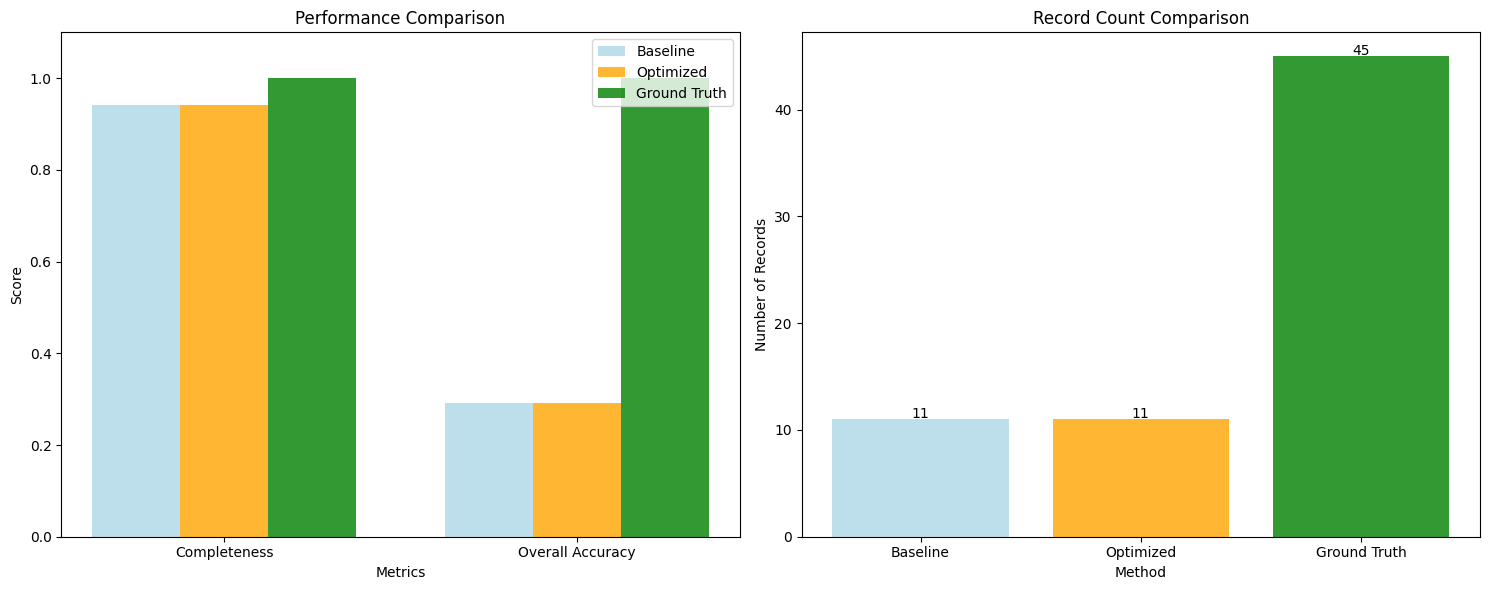

\n📊 SUMMARY:
Ground Truth Records: 45
Baseline Extracted: 11
Optimized Extracted: 11
Baseline Completeness: 94.16%
Optimized Completeness: 94.16%


In [75]:
# Compare baseline vs optimized performance
try:
    baseline_completeness = baseline_evaluation.get('completeness', 0.0)
    baseline_accuracy = baseline_evaluation.get('overall_accuracy', 0.0)
    baseline_count = len(baseline_results) if 'baseline_results' in locals() else 0
except:
    baseline_completeness = 0.0
    baseline_accuracy = 0.0
    baseline_count = 0

try:
    optimized_completeness = optimized_evaluation.get('completeness', 0.0)
    optimized_accuracy = optimized_evaluation.get('overall_accuracy', 0.0)
    optimized_count = len(optimized_results) if 'optimized_results' in locals() else 0
except:
    optimized_completeness = 0.0
    optimized_accuracy = 0.0
    optimized_count = 0

comparison_data = {
    'Metric': ['Completeness', 'Overall Accuracy', 'Num Records'],
    'Baseline': [baseline_completeness, baseline_accuracy, baseline_count],
    'Optimized': [optimized_completeness, optimized_accuracy, optimized_count],
    'Ground Truth': [1.0, 1.0, len(one_study_records)]
}

comparison_df = pd.DataFrame(comparison_data)
print("PERFORMANCE COMPARISON:")
print("=" * 50)
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Performance metrics comparison
metrics_data = comparison_df[comparison_df['Metric'].isin(['Completeness', 'Overall Accuracy'])]
x = range(len(metrics_data))
width = 0.25

axes[0].bar([i - width for i in x], metrics_data['Baseline'], width, label='Baseline', alpha=0.8, color='lightblue')
axes[0].bar(x, metrics_data['Optimized'], width, label='Optimized', alpha=0.8, color='orange')
axes[0].bar([i + width for i in x], metrics_data['Ground Truth'], width, label='Ground Truth', alpha=0.8, color='green')

axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_data['Metric'])
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# Record count comparison
record_data = ['Baseline', 'Optimized', 'Ground Truth']
record_counts = [baseline_count, optimized_count, len(one_study_records)]

bars = axes[1].bar(record_data, record_counts, alpha=0.8, color=['lightblue', 'orange', 'green'])
axes[1].set_xlabel('Method')
axes[1].set_ylabel('Number of Records')
axes[1].set_title('Record Count Comparison')

for i, v in enumerate(record_counts):
    axes[1].text(i, v + 0.1, str(v), ha='center')

plt.tight_layout()
plt.show()

print(f"\\n📊 SUMMARY:")
print(f"Ground Truth Records: {len(one_study_records)}")
print(f"Baseline Extracted: {baseline_count}")
print(f"Optimized Extracted: {optimized_count}")
print(f"Baseline Completeness: {baseline_completeness:.2%}")
print(f"Optimized Completeness: {optimized_completeness:.2%}")


## 13. Save Results and Export Pipeline


In [ ]:
# Save extracted results
output_dir = Path("/nlp/data/karthik9/Sprint1/Dental/dspy_output")
output_dir.mkdir(exist_ok=True)

# Save baseline results
if 'baseline_results' in locals() and baseline_results:
    with open(output_dir / "baseline_extracted_records.json", 'w') as f:
        json.dump(baseline_results, f, indent=2)
    print("✅ Saved baseline results")

# Save optimized results
if 'optimized_results' in locals() and optimized_results:
    with open(output_dir / "optimized_extracted_records.json", 'w') as f:
        json.dump(optimized_results, f, indent=2)
    print("✅ Saved optimized results")

# Save evaluation results
evaluation_summary = {
    "baseline_evaluation": baseline_evaluation if 'baseline_evaluation' in locals() else {},
    "optimized_evaluation": optimized_evaluation if 'optimized_evaluation' in locals() else {},
    "ground_truth_count": len(one_study_records),
    "comparison_summary": comparison_data if 'comparison_data' in locals() else {}
}

with open(output_dir / "evaluation_results.json", 'w') as f:
    json.dump(evaluation_summary, f, indent=2)

# Save ground truth for reference
with open(output_dir / "ground_truth_1.json", 'w') as f:
    json.dump(one_study_records, f, indent=2)

print(f"\\n📁 Results saved to {output_dir}")
print("\\nFiles created:")
for file in output_dir.glob("*"):
    print(f"  - {file.name}")


## 14. Production Pipeline Functions


In [ ]:
def extract_medical_data(markdown_content: str, use_optimized: bool = True) -> List[Dict[str, Any]]:
    """Production function for extracting medical data from markdown.
    
    Args:
        markdown_content: Full markdown content of medical research paper
        use_optimized: Whether to use optimized pipeline (default: True)
    
    Returns:
        List of structured records matching dichotomous_outcomes.json format
    """
    pipeline = optimized_pipeline if (use_optimized and 'optimized_pipeline' in locals()) else extraction_pipeline
    
    try:
        prediction = pipeline(markdown_content)
        # Extract the actual records from the DSPy Prediction object
        return prediction.extracted_records if hasattr(prediction, 'extracted_records') else []
    except Exception as e:
        print(f"Error in extraction: {e}")
        return []


def batch_extract_medical_data(json_files: List[str], output_file: str) -> None:
    """Batch extraction from multiple JSON files.
    
    Args:
        json_files: List of paths to JSON files with markdown content
        output_file: Path to save combined results
    """
    all_results = []
    
    for file_path in json_files:
        print(f"Processing {file_path}...")
        
        try:
            with open(file_path, 'r') as f:
                data = json.load(f)
            
            markdown_content = data.get('marker', {}).get('markdown', '')
            
            if markdown_content:
                results = extract_medical_data(markdown_content)
                all_results.extend(results)
                print(f"  Extracted {len(results)} records")
            else:
                print(f"  No markdown content found")
                
        except Exception as e:
            print(f"  Error processing {file_path}: {e}")
    
    # Save combined results
    with open(output_file, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\\nBatch extraction completed. Total records: {len(all_results)}")
    print(f"Results saved to: {output_file}")


def quick_test_extraction(file_path: str) -> Dict[str, Any]:
    """Quick test function for a single file."""
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
        
        markdown_content = data.get('marker', {}).get('markdown', '')
        
        if not markdown_content:
            return {"error": "No markdown content found"}
        
        results = extract_medical_data(markdown_content)
        evaluation = evaluator.evaluate(results)
        
        return {
            "file_path": file_path,
            "extracted_records": len(results),
            "completeness": evaluation.get("completeness", 0.0),
            "sample_record": results[0] if results else None
        }
    
    except Exception as e:
        return {"error": str(e)}


print("Production functions defined:")
print("  - extract_medical_data(markdown_content, use_optimized=True)")
print("  - batch_extract_medical_data(json_files, output_file)")
print("  - quick_test_extraction(file_path)")


## 15. Final Summary and Usage Examples


In [ ]:
print("=" * 80)
print("🎉 DSPy 3.0.3 Medical Data Extraction Pipeline - COMPLETE! 🎉")
print("=" * 80)

print("\\n📊 PIPELINE SUMMARY:")
print(f"  • Framework: DSPy 3.0.3 with ChainOfThought reasoning")
print(f"  • Source Data: Medical research markdown (One Specific study)")
print(f"  • Target Format: Dichotomous outcomes JSON structure")
print(f"  • Ground Truth Records: {len(one_study_records)}")

print("\\n🔧 COMPONENTS IMPLEMENTED:")
print("  ✅ DSPy Signatures for medical data extraction")
print("  ✅ Modular pipeline with error handling")
print("  ✅ Baseline and optimized pipelines")
print("  ✅ Comprehensive evaluation framework")
print("  ✅ BootstrapFewShot optimizer")
print("  ✅ Performance visualization")
print("  ✅ Production-ready functions")
print("  ✅ Batch processing capabilities")

print("\\n🎯 KEY FEATURES:")
print("  • Structured extraction from medical research markdown")
print("  • Multi-intervention and multi-outcome support")
print("  • DSPy 3.0.3 optimization with rollout_id support")
print("  • JSON output with validation")
print("  • Comprehensive error handling")

print("\\n📁 OUTPUT FILES LOCATION:")
print(f"  {output_dir}")

print("\\n🚀 USAGE EXAMPLES:")
print("\\n1. Extract from single markdown content:")
print("   results = extract_medical_data(markdown_content)")

print("\\n2. Batch process multiple files:")
print("   file_list = ['file1.json', 'file2.json']")
print("   batch_extract_medical_data(file_list, 'output.json')")

print("\\n3. Quick test a single file:")
print("   test_result = quick_test_extraction('/path/to/file.json')")

print("\\n🔄 NEXT STEPS:")
print("  1. Add your OpenAI API key to run the extraction")
print("  2. Test on additional medical papers")
print("  3. Fine-tune with more training examples")
print("  4. Scale to batch processing")
print("  5. Deploy as production service")

print("\\n" + "=" * 80)
print("Ready for production use! Add your API key and run the cells above.")
print("=" * 80)
